
# <font color='#FF7F50'> Population demographics for climate science</font>

Preprocess UNWPP life expectancy, Wittgenseit capital data explorer cohort size, ISIMIP gridded population data & shapefiles of country borders from natural earth, for use in demographic climate analysis

From Grant et al. 2023 (based on Thiery et al. 2021), with some small modifications

rosa.pietroiusti@vub.be 



# <font color='#FF7F50'> PART 1. Country-level </font>

## Description:
the function **preprocess_all_country_population_data()** runs all the other functions, it preprocessses population data to create as output a dictionary, **d_countries** which contains the following information on 191 countries:
- **pop_info:** (df, df_countries) DataFrame indexed by country name, with information on the country (ISO3 abbreviation, region, income group) and the total sum of population over all years from ISIMIP gridded data (! delete this pop column or have it include only 2020 or something??). Note that some small countries are unresolved in the gridded population data, and therefore have NaNs in this column. 
- **borders**: (gdf, gdf_country_borders) GeoDataFrame with country border polygons
- **population_map**: (da, da_population) DataArray with global gridded population data from ISIMIP at 0.5 spatial resolution, cropped from 1950 to 2113 (units: number of people)
- **birth_years**: (df, df_birthyears) redundant dataframe range 1950 to 2020, delete 
- **life_expectancy_5**: (df, df_life_expectancy_5) DataFrame with life expectancy at birth, calculated from e(x) at x=5, for each birth year and each country 
- **cohort_size**: (da, da_cohort_size) da with coordinates (country, time, ages) giving the cohort size for each age each year for each country, from 1950 to 2100 (units: 1'000 people)
- **mask**: 
    - mask[0] is a regionmask.Regions object which can be used to mask geospatial data, with an entry for each country (countries_regions)
    - mask[1] is a 2D float mask for each country based on the lat/ lon grid derived from the gridded population_map (countries_mask)

## Modifications made:
- added documentation to functions
- separated load_worldbank_unwpp_data into two functions, one for wb and one for unwpp, country and region metadata is still created in both. 
- removed parts of code that pulled out river basins for floods and/or mediterranean area for drought (see e.g. XXX in Luke's code)
- **get_life_expectancies**: 
    - fixed some data that was getting dropped when doing interpolation, using df.reindex instead of concat + df.index.duplicated(keep='last')
    - removed world bank from function since it is not used 
- **get_cohortsize_countries**:
    - fixed life expectancy interpolation to maintain mean (i.e. linear interpolation then implement Sabin's fix to conserve the mean over the age bracket), and force any negative numbers to zero
    - interpolated to all ages between 0 and 100 (i.e. like get_all_cohorts in Luke's script)
- **get_mask_population**
    - added dropping small countries as a flag, so they stay in there (will have NaN population in pop_info)
    - put the gdf path inside the function 
- regions analysis: **get_regions_data**
    - modified to drop the life expectancy data for all regions this is not provided for by UNWPP (i.e. we only have LI, LMI, MHI, HI) 
   

## To do / issues :
- make insertion of filepaths more flexible to be able to change input data in all functions?
- Check start and end years, also could be inputs to fxn ? 
- Put more nice plots here from sandbox scripts ? 
- **load_wb_data & load_unwpp_data**
    - modify load_wb data and load_unwpp data to intake original raw .csv or .xls files so that we can update the analysis with new WB and UNWPP data? (e.g. downloaded WPP2022 table: Single age life tables up to age 100 - Both Sexes. Only medium is available. https://population.un.org/wpp/Download/Standard/CSV/)
- **get_life_expectancies:**
    - make interpolation of life expectancy between years mean-preserving (i.e. apply Sabin's fix)
- **get_cohortsize_countries**:
    - decide ages and years to interpolate to, add warning message that tells you this ! 
- **load_wcde_data:**
    - write what scenario wcde cohort size data is from
- **get_mask_population:**
    - pop_info: Why is total population in all grid cells in all years added up in get_mask_population??? Surely you need this year by year?? If so, modify the function 
    - why are you dropping unresolved countries, can I keep them in case we use a higher resolution gridded pop product at some point or for some years? I kept them, with population NaN in pop_info
- **get_regions_data:**
    - perhaps we don't need this? all we need is the dictionary coming from get_countries_per_region? i.e. the list of country names that are in each region
- **preprocess_all_country_population_data:**
    - currently filepaths and start and end years are embedded in functions, have this take filepaths as arguments! also potentially start and end years 
    - add drop small countries as a flag here as well as in get_mask_population
    - possibly rename functions (remove "all")
    - Move init out of the function somehow
    - clean up messages coming from function

## Functions from load_manip not included
- load_GMT: load GMT trajectories for 1.5 degrees warming, NDCs etc. for impact mapping to GMT trajectories
- load_isimip: loads Lange data 
- get_cohortsize_countries & get_all_cohorts merged into one function, where i calc data for all possible years and ages, i.e. basically does what get_all_cohorts did 
 
 
Note. If I want to calculate a timeseries of exposure to attributable heatwaves per year, here I only have cohort data going back to 1950, I wonder if this is available further back from other sources. 



# <font color='#FF7F50'> PART 2. Gridscale level</font>
 
## Description:
Goes from country-level demographics to gridscale demographics by applying country-level cohort proportions to gridded population density (i.e. assumes the proportion between cohorts is constant in the country). 

## Modifications made:
- **get_gridscale_regions:** 
    - removed basins for floods and med for drought (see Luke's code to put these back in or subset in other way, or just crop to lat lon boundaries)
- **get_gridscale_popdenom:** broke it up into different functions
    - get_gridscale_population_singlecountry: multiplies cohort proportions by population density
    - get_gridscale_population: does it for all countries and outputs a list of data arrays
    - combine_gridscale_population: sums up all the country level data arrays to make a global gridded dataset of number of people of each age in each grid cell. very slow! run it only for a year at a time (takes approx. 1 minute per year)

## Issues / To do:
- **get_gridscale_population**
    - output a dictionary instead of a list?
    - output a dictionary of the ds_demography instead of just the data array? these also have life expectancy etc. (useful for emergence)
- **combine_gridscale_population**
    - make a version of this function that runs all the 3 subfunctions for a given year instead of having to output first the list as a variable and then sum it, so that I can then e.g. use this inside a fxn where I loop over years to calc # of people exposed

## Functions not included:
- resample: in utils.py

In [1]:
#netcdf4-python, regionmask (automatically imports xarray), openpyxl

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import pickle as pk
from scipy import interpolate
import regionmask
import os, sys, glob
import openpyxl
import matplotlib.pyplot as plt
import warnings
import time


pd.set_option('display.max_rows', 50)
%matplotlib inline 

/apps/brussel/RL8/skylake/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
os.getcwd()

'/vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc10419/attr-hw/attr-hw-scripts/population'

In [3]:
# if not in same location, append with path where your modules are located 

sys.path.append('/vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc10419/attr-hw/attr-hw-scripts/population') 

from population_demographics_climate import * 

# 0. Init 

Possibly move init and filepaths out of population function? and include drop_small countries as a flag in main fxn?

In [4]:
ages        = np.arange(60,-1,-1)
age_young   = 0
age_ref     = np.nanmax(ages)
age_range   = np.arange(0,105)
year_ref    = 2020
year_start  = year_ref - age_ref # can go back to 1950 for the cohort sizes, but then messes up the lifetime exposure stuff
birth_years = np.arange(year_start,year_ref+1)     
year_end    = 2113                            # based on maximum life expectancy reported in UN WPP
year_range  = np.arange(year_start,year_end+1)

In [5]:
year_range

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025,
       2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
       2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058,
       2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069,
       2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080,
       2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091,
       2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102,
       2103, 2104, 2105, 2106, 2107, 2108, 2109, 21

# PART 1. Country level

## 1. load_wb_data

In [10]:
def load_worldbank_data():
    """ load life expectancy data at birth from World Bank data, source: https://data.worldbank.org/indicator/SP.DYN.LE00.IN
    not used in final analysis, but used for metadata on the UNWPP life expectancy data 
    
    Input:
        excel files from World Bank indicator SP.DYN.LE00.IN preprocessed slightly to remove comments and headers
    
    Returns:
        meta: ([df, df]) metadata on countries (df_countries) and on regions (df_regions)
        worldbank: ([df, df]) life expectancy at birth per country (df_worldbank_country) and per region (df_worldbank_region)
    """
    
    # load World Bank life expectancy at birth data 
    worldbank_years        = np.arange(1960,2018) 
    
    df_worldbank = pd.read_excel('./data/world_bank/world_bank_life_expectancy_by_country.xls', header=None)
    worldbank_country_data = df_worldbank.iloc[:,4:].values
    worldbank_country_meta = df_worldbank.iloc[:,:4].values
    
    df_worldbank_country = pd.DataFrame(
        data=worldbank_country_data.transpose(), 
        index=worldbank_years, 
        columns=worldbank_country_meta[:,0]
    )

    df_worldbank_regions   = pd.read_excel(
        './data/world_bank/world_bank_life_expectancy_by_country.xls', 
        'world regions', 
        header=None
    )
    
    worldbank_region_data  = df_worldbank_regions.iloc[:,2:].values
    worldbank_region_meta  = df_worldbank_regions.iloc[:,:2].values
    
    df_worldbank_region    = pd.DataFrame(
        data=worldbank_region_data.transpose(), 
        index=worldbank_years, 
        columns=worldbank_region_meta[:,0]
    )

    # convert metadata in usable dataframe (the original code for this is in ms_manip.m) 
    df_countries = pd.DataFrame(worldbank_country_meta,columns=['name','abbreviation','region','incomegroup']).set_index('name')
    df_regions = pd.DataFrame(worldbank_region_meta,columns=['name','abbreviation']).set_index('name')


    # manually adjust country names with accent problems
    correct_names = {
        'CÃ´te d\'Ivoire' : 'Côte d\Ivoire', 
        'SÃ£o TomÃ© and Principe' : 'São Tomé and Principe'
    }

    df_worldbank_country.rename(columns=correct_names, inplace=True)
    df_countries.rename(index=correct_names, inplace=True)

    # bundle for communicaton
    meta = (df_countries, df_regions)
    worldbank = (df_worldbank_country, df_worldbank_region)
    
    return meta, worldbank

In [11]:
meta, worldbank = load_worldbank_data()

In [12]:
type(meta)

tuple

In [13]:
df_countries = meta[0] # df countries
df_countries

,abbreviation,region,incomegroup
name,,,
Aruba,ABW,Latin America & Caribbean,High income
Afghanistan,AFG,South Asia,Low income
Angola,AGO,Sub-Saharan Africa,Lower middle income
Albania,ALB,Europe & Central Asia,Upper middle income
United Arab Emirates,ARE,Middle East & North Africa,High income
...,...,...,...
Samoa,WSM,East Asia & Pacific,Upper middle income
Yemen,YEM,Middle East & North Africa,Low income
South Africa,ZAF,Sub-Saharan Africa,Upper middle income


In [14]:
df_regions = meta[1] # regions
df_regions

,abbreviation
name,
Arab World,ARB
Central Europe and the Baltics,CEB
Caribbean small states,CSS
East Asia & Pacific (excluding high income),EAP
Early-demographic dividend,EAR
East Asia & Pacific,EAS
Europe & Central Asia (excluding high income),ECA
Europe & Central Asia,ECS
Euro area,EMU


In [15]:
worldbank[0] # life expectancy at birth each year 1960-2017 per country

,Aruba,Afghanistan,Angola,Albania,United Arab Emirates,Argentina,Armenia,Antigua and Barbuda,Australia,Austria,...,Saint Vincent and the Grenadines,Venezuela,United States Virgin Islands,Vietnam,Vanuatu,Samoa,Yemen,South Africa,Zambia,Zimbabwe
1960,65.662,32.292,33.251,62.279,52.265,65.022,65.971,62.115,70.817073,68.585610,...,58.030,59.253,66.224854,59.041,46.441,49.748,34.361,52.215,45.124,51.565
1961,66.074,32.742,33.573,63.298,53.312,65.141,66.402,62.555,70.973171,69.577317,...,59.134,59.829,66.487976,59.722,47.044,50.249,34.471,52.559,45.502,51.938
1962,66.444,33.185,33.914,64.187,54.349,65.233,66.837,62.979,70.942439,69.309512,...,60.176,60.395,66.741098,60.391,47.648,50.750,34.739,52.894,45.869,52.300
1963,66.787,33.624,34.272,64.911,55.375,65.311,67.276,63.385,70.911707,69.443659,...,61.124,60.948,66.996220,61.024,48.251,51.252,35.187,53.229,46.225,52.651
1964,67.113,34.060,34.645,65.461,56.385,65.388,67.715,63.774,70.880976,69.921951,...,61.960,61.488,67.260366,61.585,48.853,51.756,35.815,53.571,46.574,52.993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,75.440,62.494,60.373,77.702,76.798,76.089,74.044,75.892,82.148780,81.136585,...,72.802,74.035,78.868293,75.663,71.481,74.206,64.291,59.830,59.982,58.053
2014,75.582,62.895,60.858,77.963,76.948,76.252,74.255,76.050,82.300000,81.490244,...,72.935,74.196,78.968293,75.855,71.709,74.504,64.523,60.993,60.775,59.360
2015,75.725,63.288,61.241,78.174,77.101,76.415,74.445,76.207,82.400000,81.190244,...,73.060,74.367,79.168293,76.052,71.925,74.770,64.743,61.981,61.397,60.398
2016,75.867,63.673,61.547,78.345,77.256,76.577,74.618,76.364,82.448780,81.641463,...,73.179,74.545,79.268293,76.253,72.133,75.013,64.953,62.774,61.874,61.163


In [16]:
worldbank[1] # life expectancy at birth each year per region

,Arab World,Central Europe and the Baltics,Caribbean small states,East Asia & Pacific (excluding high income),Early-demographic dividend,East Asia & Pacific,Europe & Central Asia (excluding high income),Europe & Central Asia,Euro area,European Union,...,Sub-Saharan Africa,Small states,East Asia & Pacific (IDA & IBRD countries),Europe & Central Asia (IDA & IBRD countries),Latin America & the Caribbean (IDA & IBRD countries),Middle East & North Africa (IDA & IBRD countries),South Asia (IDA & IBRD),Sub-Saharan Africa (IDA & IBRD countries),Upper middle income,World
1960,46.825065,67.821389,62.370691,45.724633,45.211423,48.456686,63.395794,67.037445,69.274484,69.280043,...,40.377012,54.749080,45.652496,63.834113,55.635090,46.631643,41.953903,40.377012,49.514392,52.572026
1961,47.407699,68.262198,62.869168,46.172871,45.880001,48.989264,63.915847,67.400613,69.645267,69.590003,...,40.816924,55.216508,46.100097,64.309330,56.119189,47.221261,42.593657,40.816924,50.037356,53.077660
1962,47.988878,68.006926,63.327450,46.893805,46.488544,49.662517,64.309371,67.493436,69.603887,69.515317,...,41.247488,55.664491,46.824953,64.628653,56.583826,47.807604,43.236553,41.247488,50.700549,53.501647
1963,48.572229,68.696047,63.742198,47.924757,47.037011,50.641270,64.673470,67.762020,69.773533,69.760074,...,41.666918,56.073982,47.863079,65.049286,57.029872,48.394186,43.883383,41.666918,51.560293,54.035490
1964,49.159167,69.052485,64.113072,49.272731,47.639740,51.842383,64.970917,68.158100,70.233497,70.226852,...,42.076340,56.468039,49.219603,65.342898,57.459475,48.983423,44.531872,42.076340,52.653642,54.715154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,70.598298,76.355163,72.779180,74.013491,68.957658,74.919015,72.062613,76.901355,81.512315,80.532232,...,58.884542,67.934894,74.053431,72.529845,74.801159,72.364567,67.881145,58.884542,74.667953,71.459878
2014,70.793957,76.675624,72.926180,74.176241,69.248640,75.085918,72.262960,77.216136,81.933417,80.919320,...,59.436515,68.279461,74.213908,72.762537,75.019686,72.572243,68.181109,59.436515,74.876398,71.692982
2015,70.994541,76.591070,73.062732,74.334974,69.516941,75.248806,72.541110,77.162203,81.569309,80.620579,...,59.939143,68.601676,74.371064,72.996814,75.231201,72.779484,68.456526,59.939143,75.089697,71.856556
2016,71.198456,76.988940,73.192408,74.492533,69.766271,75.400858,72.860353,77.498297,81.945913,80.974694,...,60.394838,68.876652,74.527656,73.323804,75.437399,72.985989,68.710533,60.394838,75.297995,72.056643


## 2. load_unwpp_data


In [17]:
def load_unwpp_data():
    """ load life expectancy data at exact age (5 years old) from UN WPP2019
    
    Input data is extracted from UNWPP2019 single age life tables, which up to age 100 for both sexes combined provide 
    a set of values showing the mortality experience of a hypothetical group of infants born at the same time and subject 
    throughout their lifetime to the specific mortality rates of a given year, from 1950 to 2020. 
    ex: Expectation of life (ex) at age x, i.e., average number of years lived subsequent to age x by those reaching age x
    source: https://population.un.org/wpp/Download/Standard/Mortality/
    see also: https://population.un.org/wpp/Download/Standard/CSV/
    life expectancy at age 5, defined as years left to live (ex) , is expressed for 5 year brackets (1950-1955, 1955-1960...2015-2020). 
    Here we assign this value to the central year in the bracket (1952, 1957...2017). Note that output is complete for countries, 
    but missing for some regions.

    Input:
        excel file from UNWPP2019 life tables (only life expectancy e(x) at age 5 as years left to live), preprocessed to match format of WB data (see .m script)
    
    Returns:
        meta:      ([df, df])   metadata on countries (df_countries) and on regions (df_regions)
        worldbank: ([df, df])   life expectancy expressed as years left to live at age 5 per country (df_unwpp_country) and per region (df_unwpp_region), 
                                every 5 years between 1952 and 2017. 
    """
    
    # get metadata from WorldBank data 
    df_worldbank = pd.read_excel('./data/world_bank/world_bank_life_expectancy_by_country.xls', header=None)
    worldbank_country_meta = df_worldbank.iloc[:,:4].values
    df_worldbank_regions   = pd.read_excel(
        './data/world_bank/world_bank_life_expectancy_by_country.xls', 
        'world regions', 
        header=None
    )
    worldbank_region_meta  = df_worldbank_regions.iloc[:,:2].values
    
    # convert metadata in usable dataframe
    df_countries = pd.DataFrame(worldbank_country_meta,columns=['name','abbreviation','region','incomegroup']).set_index('name')
    df_regions = pd.DataFrame(worldbank_region_meta,columns=['name','abbreviation']).set_index('name')
    
    # load United Nations life expectancy at age 5 data, defined as years left to live 
    # assume block is 5 instead of reported 6 years to avoid overlap and take middle of that 5-year block (so 1952 for period 1950-1955). 
    # Note. we have to subtract 5 to get birth year of 5-year old (a 5-year old in 1952 was born in 1947 and we need the latter). This is done in later function. 
    # xls file preprocessed from 'WPP2019_MORT_F16_1_LIFE_EXPECTANCY_BY_AGE_BOTH_SEXES_orig.xls'
    unwpp_years = np.arange(1952,2017+5,5)  
    df_unwpp = pd.read_excel('./data/UN_WPP/WPP2019_MORT_F16_1_LIFE_EXPECTANCY_BY_AGE_BOTH_SEXES.xlsx',header=None)
    unwpp_country_data = df_unwpp.values[:,4:]
    
    df_unwpp_country = pd.DataFrame(
        data=unwpp_country_data.transpose(), 
        index=unwpp_years, 
        columns=worldbank_country_meta[:,0]
    )

    df_unwpp_region_raw =  pd.read_excel(
        './data/UN_WPP/WPP2019_MORT_F16_1_LIFE_EXPECTANCY_BY_AGE_BOTH_SEXES.xlsx', 
        'world regions', 
        header=None
    )
    
    unwpp_region_data = df_unwpp_region_raw.values[:,2:]
    
    df_unwpp_region = pd.DataFrame(
        data=unwpp_region_data.transpose(), 
        index=unwpp_years, 
        columns=worldbank_region_meta[:,0]
    )
    
    # manually adjust country names with accent problems
    correct_names = {
        'CÃ´te d\'Ivoire' : 'Côte d\Ivoire', 
        'SÃ£o TomÃ© and Principe' : 'São Tomé and Principe'
    }

    df_unwpp_country.rename(columns=correct_names, inplace=True)
    df_countries.rename(index=correct_names, inplace=True)


    # bundle for communicaton
    meta = (df_countries, df_regions)
    unwpp = (df_unwpp_country, df_unwpp_region)
    
    return meta, unwpp

In [18]:
meta, unwpp = load_unwpp_data()

In [19]:
unwpp[0]

,Aruba,Afghanistan,Angola,Albania,United Arab Emirates,Argentina,Armenia,Antigua and Barbuda,Australia,Austria,...,Saint Vincent and the Grenadines,Venezuela,United States Virgin Islands,Vietnam,Vanuatu,Samoa,Yemen,South Africa,Zambia,Zimbabwe
1952,61.704961,42.50751,47.532938,63.341175,54.628687,63.247751,64.462258,59.258883,66.493915,65.850234,...,60.085593,59.381883,63.121186,58.342718,49.686309,57.474551,45.320833,52.706531,51.354425,55.445299
1957,64.004295,44.130045,48.162627,65.935552,57.656742,64.84111,66.181432,61.161689,67.309551,66.48007,...,63.020198,61.101669,64.6432,60.479168,51.748805,58.453668,45.294146,53.917921,52.796692,56.613682
1962,65.325372,45.790109,49.010398,69.377393,60.016171,65.433726,67.912671,62.732734,67.564438,67.305448,...,64.613651,62.718395,65.444361,62.365688,53.487693,59.242623,45.625245,54.929648,54.102346,57.727357
1967,66.342947,47.304549,50.040081,68.427967,61.924971,65.726902,69.671659,63.858686,67.405937,67.31265,...,64.900333,64.1576,66.365166,63.103894,55.121212,59.984745,47.85039,56.056154,55.037626,58.697559
1972,67.59328,48.913508,51.128594,67.952578,63.553737,66.39516,70.854457,64.6916,68.188829,67.774013,...,65.255158,65.495348,67.365558,57.700752,56.701673,60.784528,50.982734,57.280458,56.329826,59.519323
1977,68.692113,50.686378,52.136214,68.92616,65.03741,67.061434,70.296933,65.697984,69.682306,68.528489,...,65.969664,66.326462,68.315058,65.768598,58.43742,61.526842,54.205472,58.376179,56.972067,60.539957
1982,69.659977,52.709672,52.820343,69.492487,66.385422,67.956819,70.225962,67.063574,70.993882,69.342589,...,66.678938,66.980239,69.150982,67.251119,60.079119,62.312985,57.653073,59.485731,57.668753,61.909992
1987,70.013052,54.822191,53.200394,70.399644,67.577417,68.421873,67.447417,68.099708,71.979321,70.817074,...,67.189498,67.588465,70.145702,68.505041,61.483794,63.016681,59.936797,61.482441,57.884697,60.600903
1992,70.189847,56.697992,53.013686,69.475264,68.644852,69.165962,66.82855,68.79559,73.312509,71.792029,...,67.380972,68.029278,71.159838,69.568509,62.658335,63.650453,60.862564,62.051469,51.645247,54.553814
1997,70.314303,58.268364,53.126651,70.254358,69.645277,69.836159,68.136197,69.613445,74.379929,72.992272,...,67.309374,68.383559,72.227271,70.202292,63.822352,64.450205,61.425714,58.098997,47.360955,47.176273


In [20]:
unwpp[1]

# only has data for certain regions ! 

,Arab World,Central Europe and the Baltics,Caribbean small states,East Asia & Pacific (excluding high income),Early-demographic dividend,East Asia & Pacific,Europe & Central Asia (excluding high income),Europe & Central Asia,Euro area,European Union,...,Sub-Saharan Africa,Small states,East Asia & Pacific (IDA & IBRD countries),Europe & Central Asia (IDA & IBRD countries),Latin America & the Caribbean (IDA & IBRD countries),Middle East & North Africa (IDA & IBRD countries),South Asia (IDA & IBRD),Sub-Saharan Africa (IDA & IBRD countries),Upper middle income,World
1952,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,52.993547,54.356596
1957,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,54.02642,55.914659
1962,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.125577,57.328347
1967,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,61.012737,60.503296
1972,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,63.496948,62.232674
1977,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,65.016293,63.663474
1982,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,65.665723,64.535549
1987,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,66.868807,65.387782
1992,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,67.063859,65.91395
1997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,67.505043,66.402158


## 3. load_wcde_data

what scenario is this from?

In [21]:
def load_wcde_data():
    """load population si per age cohort from Wittgenstein Center Data Explorer (source: http://dataexplorer.wittgensteincentre.org/wcde-v2/)

    data description: Population Size (000's)
    De facto population in a country or region, classified by sex and by five-year age groups. Available in all scenarios and at all geographical scales. 
    Figures are presented in thousands.
    Note on input data. For each country data is sorted first by age cohort (0-4, 4-9...). So all the first data refers to the 0-4 age cohort. 
    Then they give the population size of that cohort at a snapshot every 5 years (1950, 1955, 1960...).
    Here we assign the data to the central age cohort (i.e. 0-4 assigned to 2).
    
    Input:
        excel file from WCDE preprocessed 
    
    Returns:
        wcde_years:        (arr)   years (1950,1955...2100)
        wcde_ages:         (arr)   central age of cohort (2, 7, 12... 102)
        wcde_country_data: (arr)   data given first for each age cohort (len 21), then for each year (len 31) = 31x21 = 655 columns, for each country (191 rows)
        wcde_region_data:  (arr)   data per regions, but many missing.  
    """

    wcde_years          = np.arange(1950,2105,5)       # hard coded from 'wcde_data_orig.xls' len is 31
    wcde_ages           = np.arange(2,102+5,5)         # hard coded from 'wcde_data_orig.xls' not that we assume +100 to be equal to 100-104, len is 21

    df_wcde             =  pd.read_excel('./data/Wittgenstein_Centre/wcde_data.xlsx',header=None)
    wcde_country_data   = df_wcde.values[:,4:]
    df_wcde_region      =  pd.read_excel(
        './data/Wittgenstein_Centre/wcde_data.xlsx', 
        'world regions', 
        header=None
    )
    wcde_region_data    = df_wcde_region.values[:,2:]

    return wcde_years, wcde_ages, wcde_country_data, wcde_region_data

In [22]:
wcde = load_wcde_data()
wcde_years, wcde_ages, wcde_country_data, wcde_region_data = wcde

In [23]:
wcde_years

array([1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000,
       2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055,
       2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100])

In [24]:
wcde_ages

array([  2,   7,  12,  17,  22,  27,  32,  37,  42,  47,  52,  57,  62,
        67,  72,  77,  82,  87,  92,  97, 102])

In [25]:
wcde_country_data

array([[6.7, 8.1, 8.8, ..., 0.7, 1.2, 1.7],
       [1291.6, 1355.1, 1539.5, ..., 1.1, 1.6, 2.4],
       [739.2, 1023.5, 1095.3, ..., 3.0, 4.2, 6.1],
       ...,
       [2023.8, 2563.3, 2893.8, ..., 30.3, 34.6, 39.0],
       [423.0, 483.3, 578.8, ..., 1.8, 2.4, 3.4],
       [441.6, 614.9, 725.0, ..., 3.1, 4.2, 5.7]], dtype=object)

In [26]:
wcde_region_data

array([[-999.0, -999.0, -999.0, ..., -999, -999.0, -999.0],
       [-999.0, -999.0, -999.0, ..., -999, -999.0, -999.0],
       [-999.0, -999.0, -999.0, ..., -999, -999.0, -999.0],
       ...,
       [-999.0, -999.0, -999.0, ..., -999, -999.0, -999.0],
       [-999.0, -999.0, -999.0, ..., -999, -999.0, -999.0],
       [338387.2, 405612.1, 432642.8, ..., 36321, 42244.2, 48218.6]],
      dtype=object)

## 4. load_population()

In [27]:
def load_population(
    year_start,
    year_end,
):
    """load gridded population reconstructions (histsoc) + projections (SSP2) from ISIMIP

    Gridded population density at 0.5 degrees, annual 1861-2005 (histsoc) and 2006-2100 (SPP2), expressed as number of people, concatenated
    
    Input:
        nc4 files histsoc and SSP2 
    
    Returns:
        da_population: (DataArray)  gridded population density per 0.5 degree spatial resolution, annual temporal resolution
    """

    # load 2D data
    da_population_histsoc = xr.open_dataset('./data/isimip/population/population_histsoc_0p5deg_annual_1861-2005.nc4', decode_times=False)['number_of_people'] 
    da_population_ssp2soc = xr.open_dataset('./data/isimip/population/population_ssp2soc_0p5deg_annual_2006-2100.nc4', decode_times=False)['number_of_people'] 

    # manually adjust time dimension in both data arrays (because original times could not be decoded)
    da_population_histsoc['time'] = np.arange(1861,2006)
    da_population_ssp2soc['time'] = np.arange(2006,2101)
    # concatenate historical and future data
    da_population = xr.concat([da_population_histsoc, da_population_ssp2soc], dim='time') 


    # if needed, repeat last year until entire period of interest is covered
    if np.nanmax(da_population.time) < year_end:
        population_10y_mean = da_population.loc[-10:,:,:].mean(dim='time').expand_dims(dim='time',axis=0) # repeat average of last 10 years (i.e. end-9 to end ==> 2090:2099)
        for year in range(np.nanmax(da_population.time)+1,year_end+1): 
            da_population = xr.concat([da_population,population_10y_mean.assign_coords(time = [year])], dim='time')

    # retain only period of interest
    da_population = da_population.sel(time=slice(year_start,year_end))

    return da_population

In [28]:
da_population = load_population(1950,2100)
da_population

<xarray.DataArray 'number_of_people' (time: 151, lat: 360, lon: 720)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2096 2097 2098 2099 2100
Attributes:
    units:    1
    code:     1

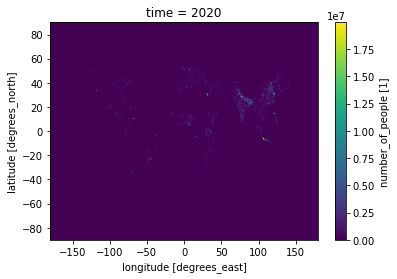

In [29]:
da_population.sel(time=2020).plot()

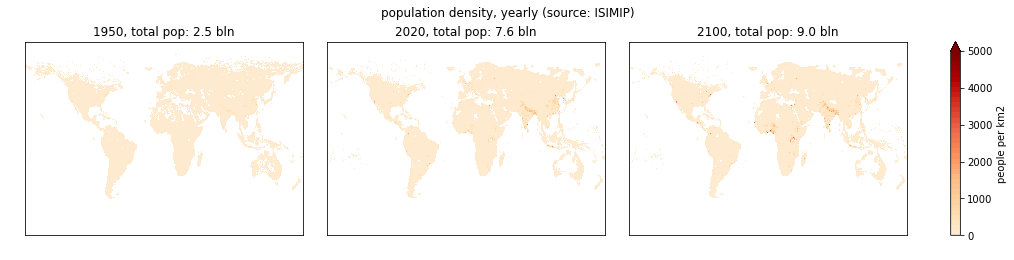

In [30]:
# plot for presentations 

import matplotlib        as mpl

cmap = mpl.cm.OrRd(np.linspace(0,1,40))
cmap = mpl.colors.ListedColormap(cmap[4:,:-1])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,3.5), layout='constrained')

im = (da_population/3025).where(da_population).sel(time=1950).plot(cmap=cmap, vmin=0, vmax=5000, add_colorbar=False, ax=ax1)
tpop = da_population.where(da_population).sel(time=1950).sum() / 1e9
ax1.set_title(f'1950, total pop: {tpop:.1f} bln')

im = (da_population/3025).where(da_population).sel(time=2020).plot(cmap=cmap, vmin=0, vmax=5000,  add_colorbar=False, ax=ax2)
tpop = da_population.where(da_population).sel(time=2020).sum() / 1e9
ax2.set_title(f'2020, total pop: {tpop:.1f} bln')

im = (da_population/3025).where(da_population).sel(time=2100).plot(cmap=cmap, vmin=0, vmax=5000, add_colorbar=False, ax=ax3)
tpop = da_population.where(da_population).sel(time=2100).sum() / 1e9
ax3.set_title(f'2100, total pop: {tpop:.1f} bln')

for ax in [ax1,ax2,ax3]:
    ax.set_ylabel(" ")
    ax.set_xlabel(" ")
    ax.set_xticks([])
    ax.set_yticks([])
    
cbar = f.colorbar(im, extend='max', use_gridspec=True, ax=[ax1,ax2,ax3],  label='people per km2') #ax=[ax1,ax2,ax3], location='bottom'
plt.suptitle('population density, yearly (source: ISIMIP)')
# cbar_kwargs={'label': 'people per km2 (approx)'}

figpath='figs/gridded_population_1950_2020_2100.png'
if not os.path.isfile(figpath):
    plt.savefig(figpath, dpi=300)
#plt.tight_layout()

In [31]:
da_population.sel(time=2020).sum()

<xarray.DataArray 'number_of_people' ()>
array(7.640119e+09, dtype=float32)
Coordinates:
    time     int64 2020

In [32]:
da_population.sel(time=2022).sum()

<xarray.DataArray 'number_of_people' ()>
array(7.770247e+09, dtype=float32)
Coordinates:
    time     int64 2022

## 5. get_life_expectancies

Fixing interpolation dropping data and removed WB from this 

What this function does:
- Takes UNWPP life expectancy data expressed as years left to live at age of 5, subtracts 5 to get it at birth year ignoring infant mortality, adds 6 to account for increase in life expectancy through the life of an individual(i.e. move from "period" life expectancy to "cohort" life expectancy, see Goldstein & Wachter (2006) "Relationships between period and cohort life expectancy: Gaps and lags")
- Interpolates linearly between years to get life expectancy in each year for each country at birth expressed in "cohort" way, neglecting infant mortality

To do:
- clean up function and documentation 
- maybe remove df_birthyears
- note. this interpolation is not mean preserving and i am currently not correcting for this !

In [154]:
def get_life_expectancies_old(
   # df_worldbank_country, 
    df_unwpp_country,
):

    # original data runs from 1960 to 2017 but we want estimates from 1960 to 2020
    # add three rows of 0s
   # df_extrayears = pd.DataFrame(
   #     np.empty([year_ref- df_worldbank_country.index.max(),len(df_worldbank_country.columns)]),
   #     columns=df_worldbank_country.columns,
   #     index=np.arange(df_worldbank_country.index.max()+1,year_ref+1,1),
   # )
   # df_worldbank_country = pd.concat([df_worldbank_country, df_extrayears]) # Luke: why does worldbank data go unused?

    # store birth_year data
    # dataframe filled with birthyears for every country
    df_birthyears = pd.DataFrame(np.transpose(np.tile(birth_years, (len(df_unwpp_country.keys()),1))) , columns=df_unwpp_country.keys(), index=birth_years)

    # extract life expectancy at age 5 data from UN WPP file and
    # linearly interpolate from 5-year WPP blocks to pre-defined birth
    # year (extrapolate from 2013 to 2020, note that UN WPP has no NaNs)
    df_birthyears_empty = pd.DataFrame(columns=df_unwpp_country.keys(), index=birth_years)
    
    df_unwpp_country_startyear = df_unwpp_country.set_index(df_unwpp_country.index.values-5)
    df_concat = pd.concat([df_unwpp_country_startyear,df_birthyears_empty]).sort_index()
    df_concat = df_concat[~df_concat.index.duplicated(keep='last')]
    df_unwpp_country_interp = df_concat.astype('float').interpolate(
        method='slinear', # original 'linear' filled end values with constants; slinear calls spline linear interp/extrap from scipy interp1d
        limit_direction='both',
        fill_value='extrapolate',
    )
    df_unwpp_country_interp = df_unwpp_country_interp[df_unwpp_country_interp.index.isin(df_birthyears_empty.index)]
    df_life_expectancy_5 = df_unwpp_country_interp + 5 + 6

    return df_birthyears, df_life_expectancy_5

In [155]:
def get_life_expectancies(
    df_unwpp_country
):
    """calculate cohort life expectancy at birth from UNWPP data
    
    Function takes UNWPP life expectancy data expressed as years left to live at age of 5, subtracts 5 from index and adds 5 to life expectancy to get it
    at birth year ignoring infant mortality, adds 6 to account for increase in life expectancy through the life of an individual (i.e. move from "period" 
    life expectancy to "cohort" life expectancy, see Goldstein & Wachter (2006) "Relationships between period and cohort life expectancy: Gaps and lags").
    This data is given every 5 years, this function then interpolates linearly for all years to get life expectancy at birth expressed in "cohort" way, 
    neglecting infant mortality, in each year for each country. 
    
    TODO: make interpolation mean-preserving ! 
 
    Input:
        df_unwpp_country: (df)  output from load_unwpp_data() 
    
    Returns:
        df_birthyears: (df)  DO WE NEED THIS ??? 
        df_life_expectancy_5: (df) cohort life expectancy at birth, neglecting infant mortality, each year for each country
    """
    # dataframe filled with birthyears for every country - do we need this ?
    df_birthyears = pd.DataFrame(np.transpose(np.tile(birth_years, (len(df_unwpp_country.keys()),1))) , columns=df_unwpp_country.keys(), index=birth_years)
    # extract life expectancy at age 5 data from UN WPP file and remove 5 from index to get the birth year
    # reindex to get a row for each year
    df_unwpp_country_startyear = df_unwpp_country.set_index(df_unwpp_country.index.values-5)
    df_concat = df_unwpp_country_startyear.reindex(
                        np.arange(
                            np.nanmin(np.concatenate((df_unwpp_country_startyear.index.values, birth_years))), 
                            np.nanmax(np.concatenate((df_unwpp_country_startyear.index.values, birth_years)))+1
                        ))
    # linearly interpolate from 5-year WPP blocks to pre-defined birth year (extrapolate from 2013 to 2020, note that UN WPP has no NaNs)
    df_unwpp_country_interp = df_concat.astype('float').interpolate(
        method='slinear', # original 'linear' filled end values with constants; slinear calls spline linear interp/extrap from scipy interp1d
        limit_direction='both',
        fill_value='extrapolate'
    )
    
    #TODO: make this mean-preserving
    df_unwpp_country_interp = df_unwpp_country_interp[df_unwpp_country_interp.index.isin(birth_years)] # remove the years you dont need 
    df_life_expectancy_5 = df_unwpp_country_interp + 5 + 6

    return df_birthyears, df_life_expectancy_5

In [156]:
df_unwpp_country = unwpp[0]
df_birthyears, df_life_expectancy_5= get_life_expectancies(df_unwpp_country)


### check datapoints no longer dropped

In [157]:
df_unwpp_country = unwpp[0]
df_birthyears_old, df_life_expectancy_5_old = get_life_expectancies_old(df_unwpp_country) 

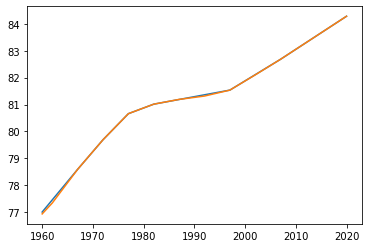

In [158]:
plt.plot(df_life_expectancy_5_old.iloc[:,0])
plt.plot(df_life_expectancy_5.iloc[:,0])

In [159]:
df_life_expectancy_5 # new

,Aruba,Afghanistan,Angola,Albania,United Arab Emirates,Argentina,Armenia,Antigua and Barbuda,Australia,Austria,...,Saint Vincent and the Grenadines,Venezuela,United States Virgin Islands,Vietnam,Vanuatu,Samoa,Yemen,South Africa,Zambia,Zimbabwe
1960,76.935917,57.698773,60.628208,79.807737,72.161451,76.609632,79.968064,74.408305,78.469337,78.309769,...,75.785660,74.581918,76.996844,73.808612,65.467804,70.687896,57.960332,66.605552,65.663514,69.309478
1961,77.139432,58.001661,60.834144,79.617852,72.543211,76.668267,80.319861,74.633496,78.437637,78.311210,...,75.842997,74.869759,77.181005,73.956253,65.794508,70.836321,58.405361,66.830853,65.850570,69.503519
1962,77.342947,58.304549,61.040081,79.427967,72.924971,76.726902,80.671659,74.858686,78.405937,78.312650,...,75.900333,75.157600,77.365166,74.103894,66.121212,70.984745,58.850390,67.056154,66.037626,69.697559
1963,77.593014,58.626341,61.257784,79.332889,73.250724,76.860554,80.908219,75.025269,78.562515,78.404923,...,75.971298,75.425150,77.565244,73.023266,66.437304,71.144702,59.476859,67.301015,66.296066,69.861912
1964,77.843080,58.948133,61.475486,79.237811,73.576477,76.994205,81.144778,75.191852,78.719094,78.497195,...,76.042263,75.692699,77.765323,71.942637,66.753396,71.304658,60.103328,67.545876,66.554506,70.026265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,83.787205,75.832352,72.903320,85.908475,84.905715,83.854096,82.395768,83.834818,90.136836,87.934313,...,79.750389,80.469459,87.742389,83.036564,78.659771,80.894440,75.984244,73.740924,76.008132,72.558423
2017,83.910129,76.064058,73.159903,86.062386,85.074772,83.977106,82.529795,83.948705,90.293881,88.003238,...,79.804572,80.481248,87.909263,83.077426,78.785848,81.039229,75.991568,74.194456,76.684871,73.178974
2018,84.033053,76.295764,73.416486,86.216297,85.243829,84.100116,82.663822,84.062592,90.450926,88.072163,...,79.858755,80.493037,88.076137,83.118288,78.911925,81.184018,75.998892,74.647988,77.361610,73.799525
2019,84.155977,76.527470,73.673069,86.370208,85.412886,84.223127,82.797849,84.176479,90.607971,88.141088,...,79.912938,80.504826,88.243012,83.159149,79.038003,81.328807,76.006216,75.101520,78.038349,74.420076


In [160]:
df_life_expectancy_5_old

,Aruba,Afghanistan,Angola,Albania,United Arab Emirates,Argentina,Armenia,Antigua and Barbuda,Australia,Austria,...,Saint Vincent and the Grenadines,Venezuela,United States Virgin Islands,Vietnam,Vanuatu,Samoa,Yemen,South Africa,Zambia,Zimbabwe
1960,77.005744,57.727129,60.645857,79.949949,72.077441,76.722156,79.795207,74.320394,78.751755,78.446018,...,75.806103,74.551481,77.020720,71.966207,65.451887,70.705195,58.232492,66.634891,65.770590,69.264947
1961,77.232535,58.039469,60.857676,79.807467,72.431197,76.818300,80.089385,74.516280,78.814194,78.492874,...,75.870254,74.829176,77.212840,71.499714,65.773285,70.859385,58.768241,66.869972,65.993338,69.444143
1962,77.459326,58.351809,61.069496,79.664986,72.784954,76.914443,80.383564,74.712167,78.876633,78.539730,...,75.934404,75.106872,77.404959,71.033220,66.094683,71.013576,59.303990,67.105053,66.216086,69.623340
1963,77.686117,58.664148,61.281316,79.522504,73.138711,77.010586,80.677743,74.908054,78.939073,78.586587,...,75.998555,75.384567,77.597079,70.566726,66.416081,71.167766,59.839738,67.340134,66.438834,69.802537
1964,77.912908,58.976488,61.493135,79.380023,73.492467,77.106730,80.971921,75.103940,79.001512,78.633443,...,76.062706,75.662262,77.789199,70.100233,66.737479,71.321957,60.375487,67.575215,66.661582,69.981733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,83.787205,75.832352,72.903320,85.908475,84.905715,83.854096,82.395768,83.834818,90.136836,87.934313,...,79.750389,80.469459,87.742389,83.036564,78.659771,80.894440,75.984244,73.740924,76.008132,72.558423
2017,83.910129,76.064058,73.159903,86.062386,85.074772,83.977106,82.529795,83.948705,90.293881,88.003238,...,79.804572,80.481248,87.909263,83.077426,78.785848,81.039229,75.991568,74.194456,76.684871,73.178974
2018,84.033053,76.295764,73.416486,86.216297,85.243829,84.100116,82.663822,84.062592,90.450926,88.072163,...,79.858755,80.493037,88.076137,83.118288,78.911925,81.184018,75.998892,74.647988,77.361610,73.799525
2019,84.155977,76.527470,73.673069,86.370208,85.412886,84.223127,82.797849,84.176479,90.607971,88.141088,...,79.912938,80.504826,88.243012,83.159149,79.038003,81.328807,76.006216,75.101520,78.038349,74.420076


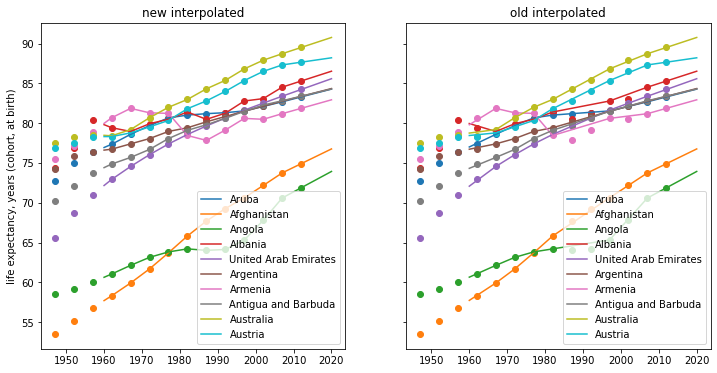

In [161]:
# check datapoints are no longer dropped

fig, (ax0, ax1) = plt.subplots(1,2, sharey=True, figsize = (12, 6))

i_start = 0 
i_stop= i_start+10

ax=ax0
df_life_expectancy_5.iloc[:,i_start:i_stop].plot(ax=ax, title = 'new interpolated')
for i in range(i_start,i_stop):
    ax.scatter(df_unwpp_country.index-5, df_unwpp_country.iloc[:,i]+11)

ax.set_ylabel('life expectancy, years (cohort, at birth)')

ax=ax1
df_life_expectancy_5_old.iloc[:,i_start:i_stop].plot(ax=ax, title = 'old interpolated') #df_unwpp_country_startyear = + 11
plt.gca().set_prop_cycle(None)
for i in range(i_start,i_stop):
    ax.scatter(df_unwpp_country.index-5, df_unwpp_country.iloc[:,i]+11)
               

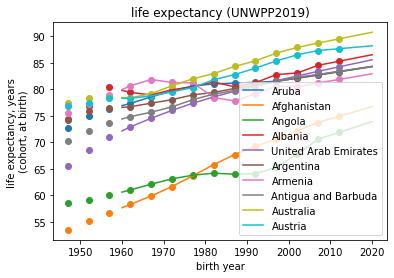

In [221]:

fig, ax0 = plt.subplots(1,1)

i_start = 0 
i_stop= i_start+10

ax=ax0
df_life_expectancy_5.iloc[:,i_start:i_stop].plot(ax=ax, title = 'life expectancy (UNWPP2019)')
for i in range(i_start,i_stop):
    ax.scatter(df_unwpp_country.index-5, df_unwpp_country.iloc[:,i]+11)

ax.set_ylabel('life expectancy, years \n(cohort, at birth)')
ax.set_xlabel('birth year')

figpath='figs/life_expectancy_interpolation.png'
if not os.path.isfile(figpath):
    plt.savefig(figpath, dpi=300)

### check mean preserved: TODO

## 6. get_cohortsize_countries


fixed linear interpolation not conserving mean issue ! But used pd dataframes instead of numpy arrays so it is a lot slower now! For consistency I should fix the mean preserving issue also in the life expectancy interpolation function

This function:
- To go from age bracket (0-4) to exact ages (0,1,2,3,4) it linearly interpolates between the values assigned to the central year, then corrects for errors introduced by the interpolation (linear interpolation is not mean-preserving), by distributing the error in each year in the age bracket with a weight that corresponds to the magnitude of the value in that particular year compared to the sum over the whole age bracket
- Then interpolates linearly between years (which are snapshots therefore mean does not need to be preserved) to get cohort size each year for each exact age 

**Note!**
-  I've modified to give all years from 1950 to 2100 (instead of 1960) and all ages from 0 to 104 (instead of 0-60)
- It's much slower now (using pandas and looping), if you want to go back to numpy interpolate.griddata I think ages 0-2 and 102-104 need to be kept constant as the interpolation function does not extrapolate. 
- neg numbers fixed now, hard coded (for 3 countries after the mean preserving correction they are re-introduced then hard coded again), ideally adapt the correction of interpolation method to adapt the correct s.t. no negative numbers emerge


In [167]:


def get_cohortsize_countries(
    wcde, 
    df_countries, 
): 
    """Linearly interpolate wcde data to get per year per exact age cohort size per country
    
    To go from age bracket (0-4) to exact ages (0,1,2,3,4) it linearly interpolates between the values 
    assigned to the central year, assigns zeros to any negative numbers, then corrects for errors introduced by 
    the interpolation (linear interpolation is not mean-preserving), by distributing the error in each year in the 
    age bracket with a weight that corresponds to the magnitude of the value in that particular year compared to the 
    sum over the whole age bracket. If any neg numbers are reintroduced (happens for 3 countries), these are forced to 
    zero. Then interpolates linearly between years (which are snapshots) to get cohort size each year for each 
    exact age. 
    
    Note. I've modified to give all years from 1950 to 2100 (instead of 1960) and all ages from 0 to 104 
    (this is like get_all_cohorts but note that Luke sorted them in descending order here I have in ascending). 
    This is basically the same as Luke's "get_all_cohorts"
    
    TODO: adapt distribute_error_across_years to not re-introduce negative numbers 
    
    Input:
        wcde: (arr of arr) output of load_wcde_data 
        df_countries: (df) metadata from load_unwpp_data 
    
    Returns:
        d_cohort_size: (dictionary of df)  for each country, a df where rows are years and columns are exact age
    """

    
    def distribute_error_across_years(df_y_values, df_y_mean_bracket, bracket_size): 
        # for a single year / single country in the dataset distribute error in age bracket
        
        # ignore warnings, we get rid of nans later with the nansum
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            
            # reshape df to array, each row is a bracket, each column is a specific age in that bracket 
            y_values = np.reshape(df_y_values.values, (len(df_y_values)//bracket_size, bracket_size)) #nrows, ncols
            # calculate interpolation error over the bracket as the sum of errors
            delta_bracket = np.sum(y_values - df_y_mean_bracket.values[:, np.newaxis], axis=1) # sums along row
            # calculate relative weights as the value divided by the sum of all values in the bracket
            sum_over_years = np.sum(y_values, axis=1)
            weights = y_values / sum_over_years[:, np.newaxis]
            # compute correction for each y value
            delta_i = weights * delta_bracket[:, np.newaxis]
            # correct the y values 
            y_corrected = np.nansum(np.dstack((y_values,-delta_i)),2).reshape(-1)
            
        return y_corrected

    # unpack loaded wcde values
    wcde_years, wcde_ages, wcde_country_data, unused = wcde 

    # initialise dictionary to store cohort sizes dataframes per country with years as rows and ages as columns
    d_cohort_size = {}

    # loop over countries
    print('interpolating cohort sizes per country')
    for i,name in enumerate(df_countries.index):
        # extract population size per age cohort data from WCDE file and linearly interpolate from 5-year WCDE blocks to pre-defined birth year
        wcde_country_data_reshape = np.reshape(wcde_country_data[i,:],((len(wcde_ages),len(wcde_years)))) 
        # every row is an age cohort (len 21), every column is a year (len 31)
        wcde_per_country = wcde_country_data_reshape
        # use dataframes to do reindexing and interpolation (see how much slower this makes it cfr. to numpy - could do with numpy interpolate.griddata if you accept that ages 0-2 are not interpolated but held constant - decide what assumption we want to use!) 
        wcde_per_country_df = pd.DataFrame(
            wcde_per_country,
            index=wcde_ages,
            columns=wcde_years
        )

        #set new coordinates after interpolation - check you want this & put in flags at start or something !! 
        ages_interpn_cohorts =  np.arange(0,105) # ISSUE: understand if OK np.arange(104,-1,-1) #np.arange(100,-1,-1) # new_ages in luke's script (prev: np.arange(0,105))
        years_interpn_cohorts = year_range # np.arange(1950,2100+1)

        # interpolate per ages
        wcde_per_country_df = wcde_per_country_df.reindex(ages_interpn_cohorts)
        wcde_per_country_df
        wcde_per_country_intrp = wcde_per_country_df.astype('float').interpolate(
                method='slinear', # original 'linear' filled end values with constants; slinear calls spline linear interp/extrap from scipy interp1d
                limit_direction='both',
                fill_value='extrapolate',
                axis=0
            )
        # set negative numbers to zero
        wcde_per_country_intrp[wcde_per_country_intrp<0]=0
        # fix the not mean preserving issue
        wcde_per_country_intrp_correct = wcde_per_country_intrp.copy()
        for y in wcde_years:
            wcde_per_country_intrp_correct.loc[:,y] = distribute_error_across_years(
                wcde_per_country_intrp.loc[:,y], # interpolated values
                wcde_per_country_df.dropna().loc[:,y], # true mean
                bracket_size=5) # bracket size 
         
        # check for neg numbers
        if (wcde_per_country_intrp_correct < 0).any().any():
            print('after interpolation and mean-preserving correction there are some neg numbers in {}, {}, setting them to zero'.format(i,name))
            # set them to zero
            wcde_per_country_intrp_correct[wcde_per_country_intrp_correct<0]=0
            # TODO: modify distribute_error_across_years to not reintroduce negative numbers 

        # interpolate between years
        wcde_per_country_df = wcde_per_country_intrp_correct.transpose().reindex(years_interpn_cohorts)
        wcde_per_country_intrp_years = wcde_per_country_df.astype('float').interpolate(
                method='slinear', # original 'linear' filled end values with constants; slinear calls spline linear interp/extrap from scipy interp1d
                limit_direction='both',
                fill_value='extrapolate',
                axis=0
            )
        d_cohort_size[name] = wcde_per_country_intrp_years / 5
   
    #  make a data array with the information from all the countries together
    da_cohort_size = xr.DataArray(
        np.asarray([v for k,v in d_cohort_size.items() if k in list(df_countries.index)]),
        coords={
            'country': ('country', list(df_countries.index)),
            'time': ('time', years_interpn_cohorts),
            'ages': ('ages', ages_interpn_cohorts),
        },
        dims=[
            'country',
            'time',
            'ages',
        ],
        name='cohort_size'
    )
    
    return da_cohort_size

In [168]:
da_cohort_size = get_cohortsize_countries(
    wcde, 
    df_countries, 
)

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero


### check interpolation issue fixed & check population totals

In [169]:
da_cohort_size

<xarray.DataArray 'cohort_size' (country: 191, time: 154, ages: 105)>
array([[[1.80800000e+00, 1.78400000e+00, 1.76000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.79040000e+00, 1.76720000e+00, 1.74400000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.77280000e+00, 1.75040000e+00, 1.72800000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [7.82400000e-01, 7.99200000e-01, 8.16000000e-01, ...,
         5.60000000e-01, 5.29600000e-01, 4.99200000e-01],
        [7.76800000e-01, 7.94400000e-01, 8.12000000e-01, ...,
         5.80000000e-01, 5.51200000e-01, 5.22400000e-01],
        [7.71200000e-01, 7.89600000e-01, 8.08000000e-01, ...,
         6.00000000e-01, 5.72800000e-01, 5.45600000e-01]],

       [[3.36492000e+02, 3.22196000e+02, 3.07900000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.46116000e+02, 3.31460000e+02, 3.16804000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.55740000e+02, 3.40724000e+02, 3.25708000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [5.52455200e+02, 5.58369600e+02, 5.64284000e+02, ...,
         7.45742715e-01, 0.00000000e+00, 0.00000000e+00],
        [5.46350400e+02, 5.52359200e+02, 5.58368000e+02, ...,
         7.74441187e-01, 0.00000000e+00, 0.00000000e+00],
        [5.40245600e+02, 5.46348800e+02, 5.52452000e+02, ...,
         8.03139659e-01, 0.00000000e+00, 0.00000000e+00]],

       [[1.57096000e+02, 1.51048000e+02, 1.45000000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.63168800e+02, 1.56870400e+02, 1.50572000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.69241600e+02, 1.62692800e+02, 1.56144000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.93512000e+02, 1.95272000e+02, 1.97032000e+02, ...,
         1.36270178e+00, 0.00000000e+00, 0.00000000e+00],
        [1.90692000e+02, 1.92428000e+02, 1.94164000e+02, ...,
         1.40990577e+00, 0.00000000e+00, 0.00000000e+00],
        [1.87872000e+02, 1.89584000e+02, 1.91296000e+02, ...,
         1.45710976e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * country  (country) <U32 'Aruba' 'Afghanistan' ... 'Zambia' 'Zimbabwe'
  * time     (time) int64 1960 1961 1962 1963 1964 ... 2109 2110 2111 2112 2113
  * ages     (ages) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103 104

In [170]:
df_cohort_size_Belgium = da_cohort_size.sel(country='Belgium').drop_vars('country').to_pandas()
df_cohort_size_Belgium

ages,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
time,,,,,,,,,,,,,,,,,,,,,
1960,153.5320,151.7360,149.94,148.1440,146.3480,143.552348,141.768768,139.985188,139.826295,139.667401,...,0.458947,0.282105,0.105263,0.086316,0.067368,0.054762,0.033333,0.011905,0.0000,0.0000
1961,154.6040,152.9520,151.30,149.6480,147.9960,145.639993,143.997259,142.354524,141.854249,141.353975,...,0.492102,0.303886,0.115671,0.094671,0.073670,0.055291,0.033333,0.011376,0.0000,0.0000
1962,155.6760,154.1680,152.66,151.1520,149.6440,147.727639,146.225749,144.723860,143.882204,143.040548,...,0.525256,0.325668,0.126079,0.103025,0.079972,0.055820,0.033333,0.010847,0.0000,0.0000
1963,156.7480,155.3840,154.02,152.6560,151.2920,149.815284,148.454240,147.093195,145.910159,144.727122,...,0.558410,0.347449,0.136487,0.111380,0.086273,0.056349,0.033333,0.010317,0.0000,0.0000
1964,157.8200,156.6000,155.38,154.1600,152.9400,151.902930,150.682730,149.462531,147.938113,146.413696,...,0.591565,0.369230,0.146895,0.119735,0.092575,0.056878,0.033333,0.009788,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2109,123.6592,124.1296,124.60,125.0704,125.5408,126.006606,126.476858,126.947111,127.425512,127.903913,...,123.648296,113.744569,103.840843,92.309045,80.777247,68.587200,57.161600,45.736000,34.3104,22.8848
2110,123.6280,124.0840,124.54,124.9960,125.4520,125.893908,126.349702,126.805495,127.285463,127.765432,...,126.011324,115.955906,105.900487,94.210923,82.521359,70.168000,58.584000,47.000000,35.4160,23.8320
2111,123.5968,124.0384,124.48,124.9216,125.3632,125.781210,126.222545,126.663879,127.145415,127.626951,...,128.374353,118.167242,107.960131,96.112802,84.265472,71.748800,60.006400,48.264000,36.5216,24.7792


In [171]:
wcde_country_data

array([[6.7, 8.1, 8.8, ..., 0.7, 1.2, 1.7],
       [1291.6, 1355.1, 1539.5, ..., 1.1, 1.6, 2.4],
       [739.2, 1023.5, 1095.3, ..., 3.0, 4.2, 6.1],
       ...,
       [2023.8, 2563.3, 2893.8, ..., 30.3, 34.6, 39.0],
       [423.0, 483.3, 578.8, ..., 1.8, 2.4, 3.4],
       [441.6, 614.9, 725.0, ..., 3.1, 4.2, 5.7]], dtype=object)

In [172]:
df_countries.index.get_loc('Belgium')

12

In [173]:
df_countries.iloc[12]

abbreviation                      BEL
region          Europe & Central Asia
incomegroup               High income
Name: Belgium, dtype: object

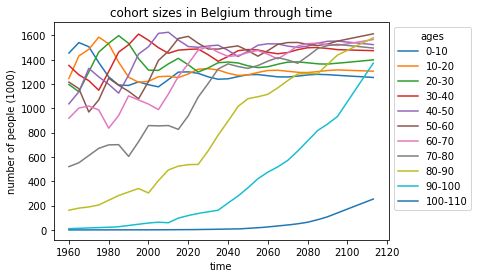

In [222]:
j = 10

df_cohort_size_Belgium.groupby(np.arange(len(df_cohort_size_Belgium.columns)) // j, axis=1).sum().plot() # group every 5 years together and calc sum and plot 
# Get the current legend
legend = plt.legend(bbox_to_anchor=(1,1), title='ages')
# Multiply the legend labels by 5
new_legend_labels = [f'{int(label.get_text()) * j}-{int(label.get_text()) * j + j}' for label in legend.get_texts()]
# Set the modified labels to the legend
for i, label in enumerate(legend.get_texts()):
    label.set_text(new_legend_labels[i])

plt.title('cohort sizes in Belgium through time')
plt.ylabel('number of people (1000)')

figpath='figs/cohortsize_belgium.png'
if not os.path.isfile(figpath):
    plt.savefig(figpath, dpi=300)


In [42]:
df_cohort_size_Belgium.loc[2020].sum() # total pop in 2020 statistics say 11.54 milion so close enough ! 

11487.5

In [43]:
np.sum(np.reshape(wcde_country_data[12,:],((len(wcde_ages),len(wcde_years)))).transpose()[np.argwhere(wcde_years ==2020)[0][0]]
      )   # original data - every row is a year, every col is age group

# perfect same result as above ! 

11487.5

### check negative numbers: HARDCODED

fixed now, hard coded but not totally conserving total population number
ideally adapt the correction of interpolation method to adapt the correct s.t. no negative numbers emerge due to correction

In [44]:
da_cohort_size.sel(country='Azerbaijan').drop_vars('country').to_pandas().loc[
    (da_cohort_size.sel(country='Azerbaijan').drop_vars('country').to_pandas() < 0).any(axis=1)]

# no more negative numbers, hard-coded


ages,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
time,,,,,,,,,,,,,,,,,,,,,


## 8. get_mask_population

Use Natural Earth dataset, only South Sudan and Palestine (Gaza + West Bank) are dropped wrt. UN WPP due to code discrepancies, reintroduce them manually. 

Don't drop unresolved countries ? Added this as a flag


In [88]:
def get_mask_population(
    da_population, 
    df_countries,
    drop_small=False
):
    """mask population per country based on gridded population and countrymask
    also communicate country masks as regionmask object 
    
    Input:
    
    Returns:
    """
    
    # open shapefile 
    gdf_country_borders =  gpd.read_file(glob.glob('./data/shapefiles/ne_countries/*.shp')[0]); 

    # load country borders; join layer with country names (to have corresponding names for later purposes) and add country index as additional column
    df_countries['name'] = df_countries.index.values
    gdf_country_borders_merge_1 = gdf_country_borders.merge(
        df_countries, 
        left_on='ADM0_A3', 
        right_on='abbreviation'
    )
    # get missing countries South Sudan and Palestine, code is in a different column
    missing_countries = ["South Sudan", "Palestine"]
    gdf_country_borders_merge_2 = gdf_country_borders.loc[gdf_country_borders['ADMIN'].isin(missing_countries)].merge(
            df_countries, 
            left_on='ISO_A3', 
            right_on='abbreviation'
        )
    # merge both geodataframes
    gdf_country_borders = gpd.GeoDataFrame(pd.concat([gdf_country_borders_merge_1,gdf_country_borders_merge_2],
                                                       ignore_index=True), crs=gdf_country_borders_merge_1.crs)

    # NEW 20 october
    # reindex the gdf to match the df !! so the masks have the same indices and you can use this in gridscale analysis
    gdf_country_borders = gdf_country_borders.set_index(gdf_country_borders.name).reindex(df_countries.index).reset_index(drop=True) 
    
    # create regionmask regions object 
    countries_regions = regionmask.from_geopandas(
        gdf_country_borders, 
        names='name', 
        abbrevs="abbreviation", 
        name="country"
    )
    countries_mask = countries_regions.mask(da_population.lon, da_population.lat)

    # loop over countries as read in by worldbank data 
    for name in df_countries.index.values: 
            # filter countries that are resolved with mask (small countries filtered out)
            if da_population.where(countries_mask==countries_regions.map_keys(name), drop=True).size != 0:
                # get mask index and sum up masked population i.e. total population in gridded dataset in that country - all years are summed ??? why ??? 
                df_countries.loc[name,'population'] = da_population.where(countries_mask==countries_regions.map_keys(name), drop=True).sum().values
            else:
                print(name, "small, population not calculated")
        
    # remove countries which have zero population at this resolution
    # added this as an option
    if drop_small == True:
        df_countries = df_countries[~df_countries.loc[:, 'population'].isnull()]
        print('dropping small countries without population calculated')
    
    # fix country borders dataframe for return
    gdf_country_borders = gdf_country_borders.set_index(gdf_country_borders.name).loc[:,['geometry','abbreviation','region']].reindex(df_countries.index)

    return  df_countries, countries_regions, countries_mask, gdf_country_borders


### Check shapefile and dropped data 

#### GADM

In [46]:
gdf_country_borders =  gpd.read_file(glob.glob('./data/shapefiles/GADM/*.shp')[0]); 
gdf_country_borders #.plot()
# try with this gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) & change the column name you are using ! 


,shapeGroup,shapeType,geometry
0,AFG,ADM0,"POLYGON ((74.88986 37.23409, 74.88962 37.23314..."
1,GBR,ADM0,"MULTIPOLYGON (((33.01302 34.64377, 33.01275 34..."
2,ALB,ADM0,"POLYGON ((20.07889 42.55580, 20.07928 42.55546..."
3,DZA,ADM0,"POLYGON ((8.64194 36.94096, 8.64195 36.94070, ..."
4,USA,ADM0,"MULTIPOLYGON (((-168.15791 -14.53181, -168.161..."
...,...,...,...
195,BEN,ADM0,"POLYGON ((0.94657 11.02311, 0.94654 11.02317, ..."
196,NER,ADM0,"POLYGON ((4.26667 19.14556, 4.29423 19.15099, ..."
197,NGA,ADM0,"MULTIPOLYGON (((6.13707 4.37177, 6.13325 4.368..."
198,None,None,"MULTIPOLYGON (((29.00000 9.67356, 28.97856 9.6..."


In [47]:
df_countries

,abbreviation,region,incomegroup
name,,,
Aruba,ABW,Latin America & Caribbean,High income
Afghanistan,AFG,South Asia,Low income
Angola,AGO,Sub-Saharan Africa,Lower middle income
Albania,ALB,Europe & Central Asia,Upper middle income
United Arab Emirates,ARE,Middle East & North Africa,High income
...,...,...,...
Samoa,WSM,East Asia & Pacific,Upper middle income
Yemen,YEM,Middle East & North Africa,Low income
South Africa,ZAF,Sub-Saharan Africa,Upper middle income


In [48]:
gdf_country_borders.merge(
        df_countries, 
        left_on='shapeGroup', 
        right_on='abbreviation'
    )
# 182 countries remain 

,shapeGroup,shapeType,geometry,abbreviation,region,incomegroup
0,AFG,ADM0,"POLYGON ((74.88986 37.23409, 74.88962 37.23314...",AFG,South Asia,Low income
1,GBR,ADM0,"MULTIPOLYGON (((33.01302 34.64377, 33.01275 34...",GBR,Europe & Central Asia,High income
2,ALB,ADM0,"POLYGON ((20.07889 42.55580, 20.07928 42.55546...",ALB,Europe & Central Asia,Upper middle income
3,DZA,ADM0,"POLYGON ((8.64194 36.94096, 8.64195 36.94070, ...",DZA,Middle East & North Africa,Upper middle income
4,USA,ADM0,"MULTIPOLYGON (((-168.15791 -14.53181, -168.161...",USA,North America,High income
...,...,...,...,...,...,...
177,MMR,ADM0,"MULTIPOLYGON (((98.03206 9.83411, 98.03333 9.8...",MMR,East Asia & Pacific,Lower middle income
178,IND,ADM0,"MULTIPOLYGON (((93.84583 7.24456, 93.84750 7.2...",IND,South Asia,Lower middle income
179,BEN,ADM0,"POLYGON ((0.94657 11.02311, 0.94654 11.02317, ...",BEN,Sub-Saharan Africa,Low income
180,NER,ADM0,"POLYGON ((4.26667 19.14556, 4.29423 19.15099, ...",NER,Sub-Saharan Africa,Low income


In [49]:
df_countries.abbreviation


name
Aruba                   ABW
Afghanistan             AFG
Angola                  AGO
Albania                 ALB
United Arab Emirates    ARE
                       ... 
Samoa                   WSM
Yemen                   YEM
South Africa            ZAF
Zambia                  ZMB
Zimbabwe                ZWE
Name: abbreviation, Length: 191, dtype: object

In [50]:
gdf_country_borders.shapeGroup

0       AFG
1       GBR
2       ALB
3       DZA
4       USA
       ... 
195     BEN
196     NER
197     NGA
198    None
199    None
Name: shapeGroup, Length: 200, dtype: object

In [51]:
df_countries[~df_countries.abbreviation.isin(gdf_country_borders.shapeGroup)]

# countries in UNWPP that are not in GADM country borders

,abbreviation,region,incomegroup
name,,,
Aruba,ABW,Latin America & Caribbean,High income
Guam,GUM,East Asia & Pacific,High income
Hong Kong,HKG,East Asia & Pacific,High income
Macao,MAC,East Asia & Pacific,High income
New Caledonia,NCL,East Asia & Pacific,High income
Puerto Rico,PRI,Latin America & Caribbean,High income
Palestine,PSE,Middle East & North Africa,Lower middle income
French Polynesia,PYF,East Asia & Pacific,High income
United States Virgin Islands,VIR,Latin America & Caribbean,High income


In [52]:
gdf_country_borders[~gdf_country_borders.shapeGroup.isin(df_countries.abbreviation)]

# countries in GADM that are not in UNWPP population data 
# Antarctica, Andorra, Dominica, Greenland, Nauru, Seychelles, Monaco, Marshall Islands, Palau, San Marino, Saint Kitts and Nevis,
# Taiwan, Tuvalu, Vatican 

,shapeGroup,shapeType,geometry
5,ATA,ADM0,"MULTIPOLYGON (((-60.06171 -79.68130, -60.06636..."
8,AND,ADM0,"POLYGON ((1.72580 42.50440, 1.71336 42.49383, ..."
52,DMA,ADM0,"POLYGON ((-61.43119 15.63581, -61.42997 15.634..."
72,GRL,ADM0,"MULTIPOLYGON (((-43.92339 59.95872, -43.92170 ..."
74,NRU,ADM0,"POLYGON ((166.94513 -0.49555, 166.94826 -0.497..."
94,XKX,ADM0,"POLYGON ((20.59429 41.87733, 20.59350 41.87874..."
96,SYC,ADM0,"MULTIPOLYGON (((51.18102 -10.11373, 51.18376 -..."
109,LIE,ADM0,"POLYGON ((9.53083 47.27054, 9.53137 47.27009, ..."
112,MCO,ADM0,"POLYGON ((7.41830 43.72460, 7.41538 43.72615, ..."
122,MHL,ADM0,"MULTIPOLYGON (((168.72420 4.57706, 168.71916 4..."


#### Natural Earth

In [53]:
gdf_country_borders =  gpd.read_file(glob.glob('./data/shapefiles/ne_countries/*.shp')[0]); 
gdf_country_borders.columns.tolist()

['featurecla',
 'scalerank',
 'LABELRANK',
 'SOVEREIGNT',
 'SOV_A3',
 'ADM0_DIF',
 'LEVEL',
 'TYPE',
 'TLC',
 'ADMIN',
 'ADM0_A3',
 'GEOU_DIF',
 'GEOUNIT',
 'GU_A3',
 'SU_DIF',
 'SUBUNIT',
 'SU_A3',
 'BRK_DIFF',
 'NAME',
 'NAME_LONG',
 'BRK_A3',
 'BRK_NAME',
 'BRK_GROUP',
 'ABBREV',
 'POSTAL',
 'FORMAL_EN',
 'FORMAL_FR',
 'NAME_CIAWF',
 'NOTE_ADM0',
 'NOTE_BRK',
 'NAME_SORT',
 'NAME_ALT',
 'MAPCOLOR7',
 'MAPCOLOR8',
 'MAPCOLOR9',
 'MAPCOLOR13',
 'POP_EST',
 'POP_RANK',
 'POP_YEAR',
 'GDP_MD',
 'GDP_YEAR',
 'ECONOMY',
 'INCOME_GRP',
 'FIPS_10',
 'ISO_A2',
 'ISO_A2_EH',
 'ISO_A3',
 'ISO_A3_EH',
 'ISO_N3',
 'ISO_N3_EH',
 'UN_A3',
 'WB_A2',
 'WB_A3',
 'WOE_ID',
 'WOE_ID_EH',
 'WOE_NOTE',
 'ADM0_ISO',
 'ADM0_DIFF',
 'ADM0_TLC',
 'ADM0_A3_US',
 'ADM0_A3_FR',
 'ADM0_A3_RU',
 'ADM0_A3_ES',
 'ADM0_A3_CN',
 'ADM0_A3_TW',
 'ADM0_A3_IN',
 'ADM0_A3_NP',
 'ADM0_A3_PK',
 'ADM0_A3_DE',
 'ADM0_A3_GB',
 'ADM0_A3_BR',
 'ADM0_A3_IL',
 'ADM0_A3_PS',
 'ADM0_A3_SA',
 'ADM0_A3_EG',
 'ADM0_A3_MA',
 'ADM0_A3_PT

In [54]:
gdf_country_borders.merge(
        df_countries, 
        left_on='ADM0_A3', # ADM0_A3
        right_on='abbreviation'
    )

# 189 countries remain 

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,abbreviation,region,incomegroup
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,...,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",IDN,East Asia & Pacific,Lower middle income
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,...,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",MYS,East Asia & Pacific,Upper middle income
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,1,Chile,...,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",CHL,Latin America & Caribbean,High income
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,1,Bolivia,...,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...",BOL,Latin America & Caribbean,Lower middle income
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,1,Peru,...,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",PER,Latin America & Caribbean,Upper middle income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,Admin-0 country,5,6,Federated States of Micronesia,FSM,0,2,Sovereign country,1,Federated States of Micronesia,...,None,None,None,None,None,None,"MULTIPOLYGON (((163.02605 5.34089, 163.03045 5...",FSM,East Asia & Pacific,Lower middle income
185,Admin-0 country,1,4,Vanuatu,VUT,0,2,Sovereign country,1,Vanuatu,...,None,None,None,None,None,None,"MULTIPOLYGON (((169.84034 -20.14080, 169.86052...",VUT,East Asia & Pacific,Lower middle income
186,Admin-0 country,5,6,United States of America,US1,1,2,Dependency,1,Guam,...,None,None,None,None,None,None,"POLYGON ((144.88640 13.64020, 144.89666 13.617...",GUM,East Asia & Pacific,High income
187,Admin-0 country,5,4,Bahrain,BHR,0,2,Sovereign country,1,Bahrain,...,None,None,None,None,None,None,"MULTIPOLYGON (((50.55161 26.19424, 50.59474 26...",BHR,Middle East & North Africa,High income


In [55]:
df_countries[~df_countries.abbreviation.isin(gdf_country_borders.ADM0_A3)]

# only Palestine and South Sudan are dropped from UN data 

,abbreviation,region,incomegroup
name,,,
Palestine,PSE,Middle East & North Africa,Lower middle income
South Sudan,SSD,Sub-Saharan Africa,Low income


In [56]:
gdf_country_borders[~gdf_country_borders.ADM0_A3.isin(df_countries.abbreviation)] #.SOVEREIGNT.tolist()

# countries in NE that aren't in UN WPP (probably a lot of these are alternative versions of countries)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
6,Admin-0 country,3,3,United Kingdom,GB1,1,2,Dependency,1,Dhekelia Sovereign Base Area,...,Admin-0 dependency,None,Admin-0 dependency,Admin-0 dependency,Admin-0 dependency,Admin-0 dependency,Admin-0 dependency,None,Admin-0 dependency,"POLYGON ((33.78094 34.97635, 33.76043 34.97968..."
11,Admin-0 country,0,5,Israel,IS1,1,2,Indeterminate,1,Palestine,...,None,None,None,None,None,None,None,Admin-0 country,None,"MULTIPOLYGON (((34.48120 31.58314, 34.52013 31..."
14,Admin-0 country,0,3,South Sudan,SDS,0,2,Sovereign country,1,South Sudan,...,None,None,None,None,None,None,None,None,None,"POLYGON ((35.92084 4.61933, 35.85654 4.61960, ..."
20,Admin-0 country,0,5,Somaliland,SOL,0,2,Sovereign country,1,Somaliland,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((48.93911 11.24913, 48.93911 11.13674..."
27,Admin-0 country,0,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.81703 27.66146, -8.81654 27.66147..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,Admin-0 country,6,5,France,FR1,1,2,Dependency,1,Clipperton Island,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-109.21203 10.30268, -109.21036 10.2..."
254,Admin-0 country,6,5,Australia,AU1,1,2,Dependency,1,Ashmore and Cartier Islands,...,None,None,None,None,None,None,None,None,None,"POLYGON ((123.59702 -12.42832, 123.59775 -12.4..."
255,Admin-0 country,6,8,Bajo Nuevo Bank (Petrel Is.),BJN,0,2,Indeterminate,1,Bajo Nuevo Bank (Petrel Is.),...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-79.98929 15.79495, -79.98782 15.796..."
256,Admin-0 country,6,5,Serranilla Bank,SER,0,2,Indeterminate,1,Serranilla Bank,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-78.63707 15.86209, -78.64041 15.864..."


<AxesSubplot:>

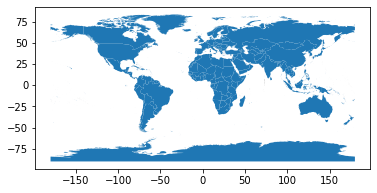

In [57]:
gdf_country_borders.plot() # full natural earth dataset

<AxesSubplot:>

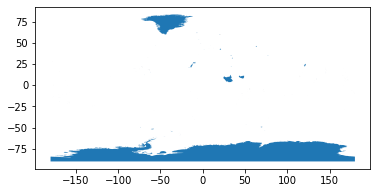

In [58]:
gdf_country_borders[~gdf_country_borders.ADM0_A3.isin(df_countries.abbreviation)].plot() # places in natural earth that aren't in UNWPP

(24.121555623000063, 39.29199914500009, 3.4902015180000916, 33.406721700000006)

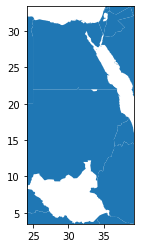

In [59]:
selection = (gdf_country_borders.ADMIN.isin(("Israel", "South Sudan", "Jordan")))
lonmin, latmin, lonmax, latmax = gdf_country_borders[selection].total_bounds

gdf_country_borders[gdf_country_borders.ADM0_A3.isin(df_countries.abbreviation)].plot() # overlap of merge, misses Palestine and South Sudan 
plt.axis([lonmin, lonmax, latmin, latmax])

(34.200269441306034, 35.88807255000012, 29.48969147300005, 33.406721700000006)

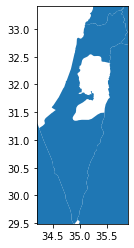

In [60]:
selection = (gdf_country_borders.ADMIN.isin(("Israel", "Palestine"))) # West bank and gaza missing 
lonmin, latmin, lonmax, latmax = gdf_country_borders[selection].total_bounds

gdf_country_borders[gdf_country_borders.ADM0_A3.isin(df_countries.abbreviation)].plot()
plt.axis([lonmin, lonmax, latmin, latmax])

In [61]:
# put them back in manually 

missing_countries = ["South Sudan", "Palestine"]
gdf_country_borders.loc[gdf_country_borders['ADMIN'].isin(missing_countries)]



,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
11,Admin-0 country,0,5,Israel,IS1,1,2,Indeterminate,1,Palestine,...,None,None,None,None,None,None,None,Admin-0 country,None,"MULTIPOLYGON (((34.48120 31.58314, 34.52013 31..."
14,Admin-0 country,0,3,South Sudan,SDS,0,2,Sovereign country,1,South Sudan,...,None,None,None,None,None,None,None,None,None,"POLYGON ((35.92084 4.61933, 35.85654 4.61960, ..."


In [62]:
gdf_country_borders.loc[gdf_country_borders['ADMIN'].isin(missing_countries)].ISO_A3
     

11    PSE
14    SSD
Name: ISO_A3, dtype: object

In [63]:
df_countries[~df_countries.abbreviation.isin(gdf_country_borders.ADM0_A3)]


,abbreviation,region,incomegroup
name,,,
Palestine,PSE,Middle East & North Africa,Lower middle income
South Sudan,SSD,Sub-Saharan Africa,Low income


In [64]:
missing_countries = ["South Sudan", "Palestine"]
gdf_country_borders.loc[gdf_country_borders['ADMIN'].isin(missing_countries)].merge(
        df_countries, 
        left_on='ISO_A3', # ADM0_A3
        right_on='abbreviation'
    )

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,abbreviation,region,incomegroup
0,Admin-0 country,0,5,Israel,IS1,1,2,Indeterminate,1,Palestine,...,None,None,None,None,Admin-0 country,None,"MULTIPOLYGON (((34.48120 31.58314, 34.52013 31...",PSE,Middle East & North Africa,Lower middle income
1,Admin-0 country,0,3,South Sudan,SDS,0,2,Sovereign country,1,South Sudan,...,None,None,None,None,None,None,"POLYGON ((35.92084 4.61933, 35.85654 4.61960, ...",SSD,Sub-Saharan Africa,Low income


In [65]:
gdf_country_borders_merge_1 = gdf_country_borders.merge(
    df_countries, 
    left_on='ADM0_A3', 
    right_on='abbreviation'
)
# get missing countries
missing_countries = ["South Sudan", "Palestine"]
gdf_country_borders_merge_2 = gdf_country_borders.loc[gdf_country_borders['ADMIN'].isin(missing_countries)].merge(
        df_countries, 
        left_on='ISO_A3', # ADM0_A3
        right_on='abbreviation'
    )

In [66]:
gdf_country_borders_merge_2

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,abbreviation,region,incomegroup
0,Admin-0 country,0,5,Israel,IS1,1,2,Indeterminate,1,Palestine,...,None,None,None,None,Admin-0 country,None,"MULTIPOLYGON (((34.48120 31.58314, 34.52013 31...",PSE,Middle East & North Africa,Lower middle income
1,Admin-0 country,0,3,South Sudan,SDS,0,2,Sovereign country,1,South Sudan,...,None,None,None,None,None,None,"POLYGON ((35.92084 4.61933, 35.85654 4.61960, ...",SSD,Sub-Saharan Africa,Low income


In [67]:
gdf_country_borders_merge = gpd.GeoDataFrame(pd.concat([gdf_country_borders_merge_1,gdf_country_borders_merge_2],
                                                       ignore_index=True), crs=gdf_country_borders_merge_1.crs)
gdf_country_borders_merge

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry,abbreviation,region,incomegroup
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,...,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",IDN,East Asia & Pacific,Lower middle income
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,...,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",MYS,East Asia & Pacific,Upper middle income
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,1,Chile,...,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",CHL,Latin America & Caribbean,High income
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,1,Bolivia,...,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...",BOL,Latin America & Caribbean,Lower middle income
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,1,Peru,...,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",PER,Latin America & Caribbean,Upper middle income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,Admin-0 country,5,6,United States of America,US1,1,2,Dependency,1,Guam,...,None,None,None,None,None,None,"POLYGON ((144.88640 13.64020, 144.89666 13.617...",GUM,East Asia & Pacific,High income
187,Admin-0 country,5,4,Bahrain,BHR,0,2,Sovereign country,1,Bahrain,...,None,None,None,None,None,None,"MULTIPOLYGON (((50.55161 26.19424, 50.59474 26...",BHR,Middle East & North Africa,High income
188,Admin-0 country,0,4,China,CH1,1,2,Country,1,Macao S.A.R,...,None,None,None,None,None,None,"MULTIPOLYGON (((113.55860 22.16303, 113.56943 ...",MAC,East Asia & Pacific,High income
189,Admin-0 country,0,5,Israel,IS1,1,2,Indeterminate,1,Palestine,...,None,None,None,None,Admin-0 country,None,"MULTIPOLYGON (((34.48120 31.58314, 34.52013 31...",PSE,Middle East & North Africa,Lower middle income


In [68]:
# reindex !!! based on gdf_country_borders



### test not dropping zero population countries

In [69]:
gdf_country_borders =  gpd.read_file(glob.glob('./data/shapefiles/ne_countries/*.shp')[0]); 
df_countries['name'] = df_countries.index.values
gdf_country_borders_merge_1 = gdf_country_borders.merge(
    df_countries, 
    left_on='ADM0_A3', 
    right_on='abbreviation'
)
# get missing countries South Sudan and Palestine, code is in a different column
missing_countries = ["South Sudan", "Palestine"]
gdf_country_borders_merge_2 = gdf_country_borders.loc[gdf_country_borders['ADMIN'].isin(missing_countries)].merge(
        df_countries, 
        left_on='ISO_A3', 
        right_on='abbreviation'
    )
# merge both geodataframes
gdf_country_borders_merge = gpd.GeoDataFrame(pd.concat([gdf_country_borders_merge_1,gdf_country_borders_merge_2],
                                                   ignore_index=True), crs=gdf_country_borders_merge_1.crs)
# create regionmask regions object 
countries_regions = regionmask.from_geopandas(
    gdf_country_borders_merge, 
    names='name', 
    abbrevs="abbreviation", 
    name="country"
)
countries_mask = countries_regions.mask(da_population.lon, da_population.lat)
for name in df_countries.index.values: 
    if da_population.where(countries_mask==countries_regions.map_keys(name), drop=True).size != 0:
        df_countries.loc[name,'population'] = da_population.where(countries_mask==countries_regions.map_keys(name), drop=True).sum().values
    else:
        print(name, "small")

Aruba small
Antigua and Barbuda small
Bahrain small
Barbados small
Federated States of Micronesia small
Grenada small
Guam small
Saint Lucia small
Macao small
Maldives small
Malta small
Singapore small
Tonga small


In [70]:
# dropped countries 
df_countries[df_countries.loc[:, 'population'].isnull()]

,abbreviation,region,incomegroup,name,population
name,,,,,
Aruba,ABW,Latin America & Caribbean,High income,Aruba,NaN
Antigua and Barbuda,ATG,Latin America & Caribbean,High income,Antigua and Barbuda,NaN
Bahrain,BHR,Middle East & North Africa,High income,Bahrain,NaN
Barbados,BRB,Latin America & Caribbean,High income,Barbados,NaN
Federated States of Micronesia,FSM,East Asia & Pacific,Lower middle income,Federated States of Micronesia,NaN
Grenada,GRD,Latin America & Caribbean,Upper middle income,Grenada,NaN
Guam,GUM,East Asia & Pacific,High income,Guam,NaN
Saint Lucia,LCA,Latin America & Caribbean,Upper middle income,Saint Lucia,NaN
Macao,MAC,East Asia & Pacific,High income,Macao,NaN


<AxesSubplot:>

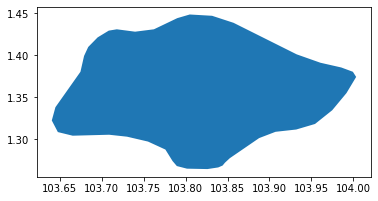

In [71]:
gdf_country_borders_merge.loc[gdf_country_borders_merge['name']=='Singapore'].plot()

In [72]:
name

'Zimbabwe'

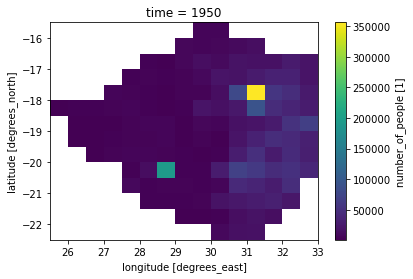

In [73]:
da_population.where(countries_mask==countries_regions.map_keys(name), drop=True)[0].plot()

### test new version

In [89]:
# mask population totals per country  and save country regions object and countries mask
df_countries, countries_regions, countries_mask, gdf_country_borders = get_mask_population(
    da_population, 
    df_countries,
) 

Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated


In [90]:
df_countries

,abbreviation,region,incomegroup,name,population
name,,,,,
Aruba,ABW,Latin America & Caribbean,High income,Aruba,NaN
Afghanistan,AFG,South Asia,Low income,Afghanistan,7.919393e+09
Angola,AGO,Sub-Saharan Africa,Lower middle income,Angola,4.118524e+09
Albania,ALB,Europe & Central Asia,Upper middle income,Albania,4.010122e+08
United Arab Emirates,ARE,Middle East & North Africa,High income,United Arab Emirates,1.088290e+09
...,...,...,...,...,...
Samoa,WSM,East Asia & Pacific,Upper middle income,Samoa,3.891671e+06
Yemen,YEM,Middle East & North Africa,Low income,Yemen,5.516871e+09
South Africa,ZAF,Sub-Saharan Africa,Upper middle income,South Africa,6.855541e+09


In [93]:
gdf_country_borders

,geometry,abbreviation,region
name,,,
Aruba,"POLYGON ((-69.99694 12.57758, -69.93639 12.531...",ABW,Latin America & Caribbean
Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",AFG,South Asia
Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",AGO,Sub-Saharan Africa
Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",ALB,Europe & Central Asia
United Arab Emirates,"MULTIPOLYGON (((56.27906 25.62745, 56.30030 25...",ARE,Middle East & North Africa
...,...,...,...
Samoa,"MULTIPOLYGON (((-172.20104 -13.59254, -172.197...",WSM,East Asia & Pacific
Yemen,"MULTIPOLYGON (((51.97861 18.99564, 51.98569 18...",YEM,Middle East & North Africa
South Africa,"MULTIPOLYGON (((19.98145 -24.75249, 19.98641 -...",ZAF,Sub-Saharan Africa


In [91]:
countries_regions

<regionmask.Regions>
Name:     country
overlap:  False

Regions:
  0 ABW                Aruba
  1 AFG          Afghanistan
  2 AGO               Angola
  3 ALB              Albania
  4 ARE United Arab Emirates
 ..  ..                  ...
186 WSM                Samoa
187 YEM                Yemen
188 ZAF         South Africa
189 ZMB               Zambia
190 ZWE             Zimbabwe

[191 regions]

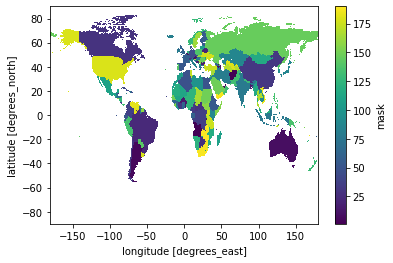

In [92]:
countries_mask.plot()

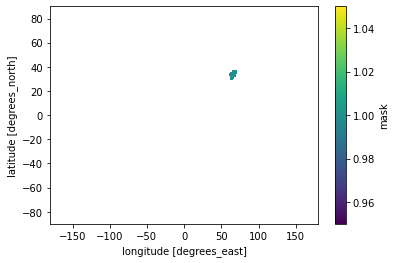

In [101]:
countries_mask.where(countries_mask==1).plot()

# 1 is afghanistan !

## 9. get_countries_per_region

In [ ]:
def get_countries_per_region(
    df_countries, 
    df_regions,
):
    """get countries per region, returns dictionary with regions as keys and countries as values

    Input:
    
    Returns:
    """
    
    d_region_countries = {}
    for region in df_regions.index:
        if df_countries.loc[df_countries['region']==region].index.values.size > 0: # if not empty
            d_region_countries[region] = df_countries.loc[df_countries['region']==region].index.values
        elif df_countries.loc[df_countries['incomegroup']==region].index.values.size > 0: # if not empty
            d_region_countries[region] = df_countries.loc[df_countries['incomegroup']==region].index.values
        elif region == 'World': # take all countries
            d_region_countries[region] = df_countries.index.values
            
    return d_region_countries

## 10. get_regions_data

In [ ]:
def get_regions_data(
    df_countries, 
    df_regions, 
    df_unwpp_region, 
    da_cohort_size,
):
    """Get life expectancy, birth years and cohort weights per region, as well as countries per region
    weighted average of life expectancy for the region (Maybe Luke has done this somewhere else) 
    Not sure we need this function, maybe we only need d_regions_countries ? to subset within d_countries? not sure... 

    Input:
    
    Returns:
    """
    
    # get countries per region
    d_region_countries = get_countries_per_region(df_countries, df_regions)

    # filter for regions used
    df_regions = df_regions[df_regions.index.isin(d_region_countries.keys())]
    df_unwpp_region = df_unwpp_region.filter(items=d_region_countries.keys())

    # get birthyears and life expectancy for regions
    df_birthyears_regions, df_life_expectancy_5_regions = get_life_expectancies(df_unwpp_region) # the life expectancy you get like this is only available for some regions, make new version
    
    # set unavailable estimates to NaN
    #df_life_expectancy_5_regions[df_life_expectancy_5_regions==12]=np.nan
    
    # TOOD: fill them with weighted life expectancy
    #df_life_expectancy_5_regions = 'to calculate' # you have to take a mean of the life expectancy of all the countries in the region weighted by the total population each year over the whole region, do this later ! 
    
    # new ages
    ages_interpn_cohorts = np.arange(0,105)
    
    # get total population in the region per cohort in 2020
    #cohort_size_year_ref = np.asarray([d_cohort_size[country].loc[year_ref] for country in d_cohort_size.keys()])
    
    # new version now that it is da_cohortsize
    cohort_size_year_ref = np.asarray([da_cohort_size.sel(country=country, time=year_ref) for country in da_cohort_size.country.values])
    
    df_cohort_size_year_ref = pd.DataFrame(
        cohort_size_year_ref,
        index=df_countries.index, 
        columns=ages_interpn_cohorts
    )
    d_cohort_weights_regions = {}
    for region in d_region_countries.keys():
        d_cohort_weights_regions[region] = df_cohort_size_year_ref[df_cohort_size_year_ref.index.isin(d_region_countries[region])].transpose()
    
    return d_region_countries, df_birthyears_regions, df_life_expectancy_5_regions,  d_cohort_weights_regions



## 11. one function to rule them all: preprocess_all_country_population_data and preprocess_all_regions_population_data



In [185]:
def preprocess_all_country_population_data(drop_small=False):
    """Preprocess all demographic data for all countries, at country level. Calls all the previous functions. 

    TODO/ISSUES:
    - possibly define filepaths in this function or outside of all the functions
    - possibly split "mask" object into 2? And understand better how it works 
    - check the "info_pop" total is what we really want ? 
    - possibly delete "birth_years", not necessary? 
    - rename life_expectancy_5 as life_expectancy? 

    Input:
    
    Returns:
    """
    
    # 1. life expectancy
    # -------------------
    
    # load worldbank and unwpp life expectancy data 
    meta, worldbank = load_worldbank_data()
    meta, unwpp = load_unwpp_data()

    # unpack values
    df_countries, df_regions = meta
    df_worldbank_country, df_worldbank_region = worldbank
    df_unwpp_country, df_unwpp_region = unwpp

    # manipulate unwpp data to get life expectancy values at birth, interpolate for each year
    df_birthyears, df_life_expectancy_5 = get_life_expectancies(
        df_unwpp_country
    )
    
    # 2. cohort sizes
    # ----------------
    
    # load population size per age cohort data from wcde
    wcde = load_wcde_data() 

    # manipulate wcde population size per age cohort data, interpolate to get values for each age and each year
    da_cohort_size = get_cohortsize_countries(
        wcde, 
        df_countries,
    )

    # 3. gridded population and country masks
    # ----------------------------------------

    # Load SSP gridded population from ISIMIP
    da_population = load_population(
        year_start,
        year_end,
    )
    
    # mask population totals per country  and save country regions object and countries mask 
    # why are you summing over all population in all years ??? surely you want this only for a single year???
    df_countries, countries_regions, countries_mask, gdf_country_borders = get_mask_population(
        da_population, 
        df_countries,
        drop_small=drop_small
    ) 
    
    # if you have dropped countries based on masking, accordingly update cohort sizes and life expectancy tables 
    da_cohort_size = da_cohort_size.loc[{'country':list(df_countries.index)}]
    df_life_expectancy_5 = df_life_expectancy_5.loc[:,list(df_countries.index)]

    # pack country information
    d_countries = {
        'info_pop': df_countries, # check the sum over all years is what we want 
        'borders': gdf_country_borders,
        'population_map': da_population,
        'birth_years': df_birthyears,  # dont need this ? 
        'life_expectancy_5': df_life_expectancy_5, # rename just life_expectancy ? 
        'cohort_size': da_cohort_size,
        'mask': (countries_regions,countries_mask), # possibly split these up into 2 ! 
    }
    

    return d_countries


In [186]:
def preprocess_all_regions_population_data(d_countries):
    """Preprocess all demographic data at region level. Calls previous functions and is based on country-level preprocessed data 
    
    ISSUES/QUESTIONS:
    - do we want anything else in this dictionary?
    - check the life_expectancy, not ok 
    - is Luke using this or not ? maybe we don't need this function and all we need is d_regions_countries?

    Input:
    
    Returns:
    """

    # load worldbank and unwpp life expectancy data 
    meta, unused = load_worldbank_data()
    meta, unwpp = load_unwpp_data()

    # unpack values
    df_countries, df_regions = meta
    df_unwpp_country, df_unwpp_region = unwpp

    da_cohort_size = d_countries['cohort_size']
    
    d_region_countries, df_birthyears_regions, df_life_expectancy_5_regions, d_cohort_weights_regions = get_regions_data(
        df_countries, 
        df_regions, 
        df_unwpp_region, 
        da_cohort_size,
    )
    
    def drop_columns_equal_to_value(dataframe, value):
        columns_to_drop = [col for col in dataframe.columns if all(dataframe[col] == value)]
        dataframe = dataframe.drop(columns=columns_to_drop)
        
        return dataframe

    df_life_expectancy_5_regions = drop_columns_equal_to_value(df_life_expectancy_5_regions, 12)


    # pack region information
    d_regions = {
        'countries_in_region': d_region_countries,
        'birth_years' : df_birthyears_regions, # delete this ? 
        'life_expectancy_5': df_life_expectancy_5_regions, # something wrong here ! 
        'cohort_size' : d_cohort_weights_regions, # ok, its a dictionary not a da like the one in the countries dictionary 
    }
    
    return d_regions

## Check output of country-level function

### 1. countries 

In [187]:
d_countries = preprocess_all_country_population_data()

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero
Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated


In [188]:
list(d_countries.keys())

['info_pop',
 'borders',
 'population_map',
 'birth_years',
 'life_expectancy_5',
 'cohort_size',
 'mask']

In [189]:
d_countries['info_pop'] # population is the total sum over all years for the gridded dataset (why are you doing this ?????)

,abbreviation,region,incomegroup,name,population
name,,,,,
Aruba,ABW,Latin America & Caribbean,High income,Aruba,NaN
Afghanistan,AFG,South Asia,Low income,Afghanistan,8.287912e+09
Angola,AGO,Sub-Saharan Africa,Lower middle income,Angola,4.309270e+09
Albania,ALB,Europe & Central Asia,Upper middle income,Albania,4.134898e+08
United Arab Emirates,ARE,Middle East & North Africa,High income,United Arab Emirates,1.147075e+09
...,...,...,...,...,...
Samoa,WSM,East Asia & Pacific,Upper middle income,Samoa,3.977283e+06
Yemen,YEM,Middle East & North Africa,Low income,Yemen,5.786329e+09
South Africa,ZAF,Sub-Saharan Africa,Upper middle income,South Africa,7.105407e+09


In [190]:
d_countries['borders'] # geodataframe of country borders

,geometry,abbreviation,region
name,,,
Aruba,"POLYGON ((-69.99694 12.57758, -69.93639 12.531...",ABW,Latin America & Caribbean
Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",AFG,South Asia
Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",AGO,Sub-Saharan Africa
Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",ALB,Europe & Central Asia
United Arab Emirates,"MULTIPOLYGON (((56.27906 25.62745, 56.30030 25...",ARE,Middle East & North Africa
...,...,...,...
Samoa,"MULTIPOLYGON (((-172.20104 -13.59254, -172.197...",WSM,East Asia & Pacific
Yemen,"MULTIPOLYGON (((51.97861 18.99564, 51.98569 18...",YEM,Middle East & North Africa
South Africa,"MULTIPOLYGON (((19.98145 -24.75249, 19.98641 -...",ZAF,Sub-Saharan Africa


In [191]:
d_countries['population_map'] # isimip world population map 1950-2100 (there are other years, we have cropped them out)

<xarray.DataArray 'number_of_people' (time: 154, lat: 360, lon: 720)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) int64 1960 1961 1962 1963 1964 ... 2109 2110 2111 2112 2113
Attributes:
    units:    1
    code:     1

In [192]:
d_countries['birth_years'] # i think we dont need this 


,Aruba,Afghanistan,Angola,Albania,United Arab Emirates,Argentina,Armenia,Antigua and Barbuda,Australia,Austria,...,Saint Vincent and the Grenadines,Venezuela,United States Virgin Islands,Vietnam,Vanuatu,Samoa,Yemen,South Africa,Zambia,Zimbabwe
1960,1960,1960,1960,1960,1960,1960,1960,1960,1960,1960,...,1960,1960,1960,1960,1960,1960,1960,1960,1960,1960
1961,1961,1961,1961,1961,1961,1961,1961,1961,1961,1961,...,1961,1961,1961,1961,1961,1961,1961,1961,1961,1961
1962,1962,1962,1962,1962,1962,1962,1962,1962,1962,1962,...,1962,1962,1962,1962,1962,1962,1962,1962,1962,1962
1963,1963,1963,1963,1963,1963,1963,1963,1963,1963,1963,...,1963,1963,1963,1963,1963,1963,1963,1963,1963,1963
1964,1964,1964,1964,1964,1964,1964,1964,1964,1964,1964,...,1964,1964,1964,1964,1964,1964,1964,1964,1964,1964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,...,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016
2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,...,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,...,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018
2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,...,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019


In [193]:
d_countries['life_expectancy_5'] # life expectancy at birth, calculated from ex at x=5 

,Aruba,Afghanistan,Angola,Albania,United Arab Emirates,Argentina,Armenia,Antigua and Barbuda,Australia,Austria,...,Saint Vincent and the Grenadines,Venezuela,United States Virgin Islands,Vietnam,Vanuatu,Samoa,Yemen,South Africa,Zambia,Zimbabwe
1960,76.935917,57.698773,60.628208,79.807737,72.161451,76.609632,79.968064,74.408305,78.469337,78.309769,...,75.785660,74.581918,76.996844,73.808612,65.467804,70.687896,57.960332,66.605552,65.663514,69.309478
1961,77.139432,58.001661,60.834144,79.617852,72.543211,76.668267,80.319861,74.633496,78.437637,78.311210,...,75.842997,74.869759,77.181005,73.956253,65.794508,70.836321,58.405361,66.830853,65.850570,69.503519
1962,77.342947,58.304549,61.040081,79.427967,72.924971,76.726902,80.671659,74.858686,78.405937,78.312650,...,75.900333,75.157600,77.365166,74.103894,66.121212,70.984745,58.850390,67.056154,66.037626,69.697559
1963,77.593014,58.626341,61.257784,79.332889,73.250724,76.860554,80.908219,75.025269,78.562515,78.404923,...,75.971298,75.425150,77.565244,73.023266,66.437304,71.144702,59.476859,67.301015,66.296066,69.861912
1964,77.843080,58.948133,61.475486,79.237811,73.576477,76.994205,81.144778,75.191852,78.719094,78.497195,...,76.042263,75.692699,77.765323,71.942637,66.753396,71.304658,60.103328,67.545876,66.554506,70.026265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,83.787205,75.832352,72.903320,85.908475,84.905715,83.854096,82.395768,83.834818,90.136836,87.934313,...,79.750389,80.469459,87.742389,83.036564,78.659771,80.894440,75.984244,73.740924,76.008132,72.558423
2017,83.910129,76.064058,73.159903,86.062386,85.074772,83.977106,82.529795,83.948705,90.293881,88.003238,...,79.804572,80.481248,87.909263,83.077426,78.785848,81.039229,75.991568,74.194456,76.684871,73.178974
2018,84.033053,76.295764,73.416486,86.216297,85.243829,84.100116,82.663822,84.062592,90.450926,88.072163,...,79.858755,80.493037,88.076137,83.118288,78.911925,81.184018,75.998892,74.647988,77.361610,73.799525
2019,84.155977,76.527470,73.673069,86.370208,85.412886,84.223127,82.797849,84.176479,90.607971,88.141088,...,79.912938,80.504826,88.243012,83.159149,79.038003,81.328807,76.006216,75.101520,78.038349,74.420076


In [194]:
d_countries['cohort_size'] # data_array, for each country the cohort size for each age each year, in 100k people 

<xarray.DataArray 'cohort_size' (country: 191, time: 154, ages: 105)>
array([[[1.80800000e+00, 1.78400000e+00, 1.76000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.79040000e+00, 1.76720000e+00, 1.74400000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.77280000e+00, 1.75040000e+00, 1.72800000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [7.82400000e-01, 7.99200000e-01, 8.16000000e-01, ...,
         5.60000000e-01, 5.29600000e-01, 4.99200000e-01],
        [7.76800000e-01, 7.94400000e-01, 8.12000000e-01, ...,
         5.80000000e-01, 5.51200000e-01, 5.22400000e-01],
        [7.71200000e-01, 7.89600000e-01, 8.08000000e-01, ...,
         6.00000000e-01, 5.72800000e-01, 5.45600000e-01]],

       [[3.36492000e+02, 3.22196000e+02, 3.07900000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.46116000e+02, 3.31460000e+02, 3.16804000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.55740000e+02, 3.40724000e+02, 3.25708000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [5.52455200e+02, 5.58369600e+02, 5.64284000e+02, ...,
         7.45742715e-01, 0.00000000e+00, 0.00000000e+00],
        [5.46350400e+02, 5.52359200e+02, 5.58368000e+02, ...,
         7.74441187e-01, 0.00000000e+00, 0.00000000e+00],
        [5.40245600e+02, 5.46348800e+02, 5.52452000e+02, ...,
         8.03139659e-01, 0.00000000e+00, 0.00000000e+00]],

       [[1.57096000e+02, 1.51048000e+02, 1.45000000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.63168800e+02, 1.56870400e+02, 1.50572000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.69241600e+02, 1.62692800e+02, 1.56144000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.93512000e+02, 1.95272000e+02, 1.97032000e+02, ...,
         1.36270178e+00, 0.00000000e+00, 0.00000000e+00],
        [1.90692000e+02, 1.92428000e+02, 1.94164000e+02, ...,
         1.40990577e+00, 0.00000000e+00, 0.00000000e+00],
        [1.87872000e+02, 1.89584000e+02, 1.91296000e+02, ...,
         1.45710976e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * country  (country) <U32 'Aruba' 'Afghanistan' ... 'Zambia' 'Zimbabwe'
  * time     (time) int64 1960 1961 1962 1963 1964 ... 2109 2110 2111 2112 2113
  * ages     (ages) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103 104

In [195]:
d_countries['mask'][0]

<regionmask.Regions>
Name:     country
overlap:  False

Regions:
  0 ABW                Aruba
  1 AFG          Afghanistan
  2 AGO               Angola
  3 ALB              Albania
  4 ARE United Arab Emirates
 ..  ..                  ...
186 WSM                Samoa
187 YEM                Yemen
188 ZAF         South Africa
189 ZMB               Zambia
190 ZWE             Zimbabwe

[191 regions]

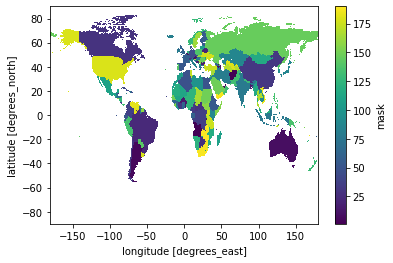

In [196]:
d_countries['mask'][1].plot()

In [197]:
# unpack 
df_countries = d_countries['info_pop']
gdf_country_borders = d_countries['borders']
da_population = d_countries['population_map']
df_birthyears = d_countries['birth_years']
df_life_expectancy_5 = d_countries['life_expectancy_5']
da_cohort_size = d_countries['cohort_size']
countries_regions, countries_mask = d_countries['mask'] 


### 2. regions

In [198]:
d_regions = preprocess_all_regions_population_data(d_countries)

In [199]:
list(d_regions.keys())

['countries_in_region', 'birth_years', 'life_expectancy_5', 'cohort_size']

In [200]:
d_regions['countries_in_region']['World']

array(['Aruba', 'Afghanistan', 'Angola', 'Albania',
       'United Arab Emirates', 'Argentina', 'Armenia',
       'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Burkina Faso', 'Bangladesh',
       'Bulgaria', 'Bahrain', 'Bahamas', 'Bosnia and Herzegovina',
       'Belarus', 'Belize', 'Bolivia', 'Brazil', 'Barbados',
       'Brunei Darussalam', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', 'Côte d\\Ivoire', 'Cameroon',
       'Democratic Republic of the Congo', 'Republic of Congo',
       'Colombia', 'Comoros', 'Cape Verde', 'Costa Rica', 'Cuba',
       'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Denmark',
       'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt', 'Eritrea',
       'Spain', 'Estonia', 'Ethiopia', 'Finland', 'Fiji', 'France',
       'Federated States of Micronesia', 'Gabon', 'United Kingdom',
       'Georgia', 'Ghana', 'Guinea', 'The Gambia', 'Guinea

In [201]:
len(d_regions['countries_in_region']['World'])

191

In [202]:
d_regions['birth_years'] # delete this ? 

,East Asia & Pacific,Europe & Central Asia,High income,Latin America & Caribbean,Low income,Lower middle income,Middle East & North Africa,North America,South Asia,Sub-Saharan Africa,Upper middle income,World
1960,1960,1960,1960,1960,1960,1960,1960,1960,1960,1960,1960,1960
1961,1961,1961,1961,1961,1961,1961,1961,1961,1961,1961,1961,1961
1962,1962,1962,1962,1962,1962,1962,1962,1962,1962,1962,1962,1962
1963,1963,1963,1963,1963,1963,1963,1963,1963,1963,1963,1963,1963
1964,1964,1964,1964,1964,1964,1964,1964,1964,1964,1964,1964,1964
...,...,...,...,...,...,...,...,...,...,...,...,...
2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016
2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018
2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019


In [203]:
d_regions['life_expectancy_5'] # this was taken from the WB life expectancy, but this is only available for some of the regions 

,High income,Low income,Lower middle income,Upper middle income,World
1960,78.208399,61.481898,66.047928,69.657873,70.233316
1961,78.291412,61.781752,66.501273,70.835305,70.868306
1962,78.374425,62.081606,66.954619,72.012737,71.503296
1963,78.508971,62.412645,67.288820,72.509580,71.849172
1964,78.643516,62.743684,67.623022,73.006422,72.195047
...,...,...,...,...,...
2016,87.725750,75.554076,78.280954,83.608661,82.029300
2017,87.831313,75.886923,78.452851,83.856183,82.223565
2018,87.936877,76.219770,78.624748,84.103704,82.417830
2019,88.042440,76.552617,78.796645,84.351226,82.612096


In [204]:
d_regions['cohort_size']['Europe & Central Asia'] # cohort size in 2020 

name,Albania,Armenia,Austria,Azerbaijan,Belgium,Bulgaria,Bosnia and Herzegovina,Belarus,Switzerland,Cyprus,...,Russian Federation,Serbia,Slovakia,Slovenia,Sweden,Tajikistan,Turkmenistan,Turkey,Ukraine,Uzbekistan
0,32.104000,37.984000,82.028000,144.404000,128.460000,61.584000,30.400000,97.764000,90.580000,14.224000,...,1519.308000,91.11600,55.740000,19.816000,123.908000,222.156000,136.204000,1223.308000,422.660000,620.640000
1,32.172000,38.232000,82.224000,148.312000,128.800000,62.132000,30.360000,100.272000,90.220000,14.112000,...,1571.404000,91.20800,55.880000,20.148000,123.284000,223.288000,135.952000,1240.324000,431.220000,622.800000
2,32.240000,38.480000,82.420000,152.220000,129.140000,62.680000,30.320000,102.780000,89.860000,14.000000,...,1623.500000,91.30000,56.020000,20.480000,122.660000,224.420000,135.700000,1257.340000,439.780000,624.960000
3,32.308000,38.728000,82.616000,156.128000,129.480000,63.228000,30.280000,105.288000,89.500000,13.888000,...,1675.596000,91.39200,56.160000,20.812000,122.036000,225.552000,135.448000,1274.356000,448.340000,627.120000
4,32.376000,38.976000,82.812000,160.036000,129.820000,63.776000,30.240000,107.796000,89.140000,13.776000,...,1727.692000,91.48400,56.300000,21.144000,121.412000,226.684000,135.196000,1291.372000,456.900000,629.280000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.055556,0.189474,0.743129,0.057895,1.073825,0.118182,0.114286,0.284884,0.926609,0.053846,...,4.064348,0.17541,0.172222,0.116239,1.291318,0.107692,0.051515,0.578014,1.203476,0.768831
101,0.033333,0.129825,0.433333,0.033333,0.633333,0.066667,0.066667,0.166667,0.566667,0.033333,...,2.433333,0.10000,0.100000,0.066667,0.800000,0.066667,0.033333,0.333333,0.700000,0.522944
102,0.011111,0.070175,0.123538,0.008772,0.192842,0.015152,0.019048,0.048450,0.206724,0.012821,...,0.802319,0.02459,0.027778,0.017094,0.308682,0.025641,0.015152,0.088652,0.196524,0.277056
103,0.000000,0.010526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031169


# PART 2. Gridscale level

## 1. get_gridscale_regions

Move filepath of grid area outside ? Can add flags to subset some countries. See Luke's original function for examples.

In [205]:
def get_gridscale_regions(
    gdf_country_borders,
):
    
    #grid_area = xr.open_dataarray('./data/isimip/clm45_area.nc4')

    #lat = grid_area.lat.values
    #lon = grid_area.lon.values  
    
    # ADD OPTIONS & FLAGS HERE TO SUBSET ONLY SOME COUNTRIES
    # See Luke's original function for options
    
    gdf_country = gdf_country_borders.loc[:,'geometry']
    list_countries = gdf_country.index.values        
            
    return list_countries

In [206]:
gridscale_countries = get_gridscale_regions(
    gdf_country_borders,
)

len(gridscale_countries)

191

## 2. get_gridscale_popdenom > get_gridscale_population

Broke this up in different functions:
- **get_gridscale_population_singlecountry()** : just one country and plug it into fxns with loops, multiplies gridded population by cohort proportions
- **get_gridscale_population()** : output all da as a list or dictionary (latter better?). Now outputting a list of data arrays of each country. Decide whether to do this or just make a fxn that does analysis for one country and plug this in to whatever other exposure function you are running and in a function where you extract global map of population for 1 or few years.
- **combine_gridscale_population(startyear, endyear)** : combine the da's or ds's of each country into a global gridded product for 1 or few year (align+sum)

To do:
- Decide whether to output a list of DA's or a list of DS's with the life, birth death etc. information that Luke was saving as well for the alignment (maybe the latter better for later alignment and exposure calculation?)
- soft-code the saving filepath etc
- Decide whether to combine all 3 functions to run them together based only on year you want instead of outputting and saving list with everything
- Plug these into exposure functions etc. 

In [207]:
def get_gridscale_population_singlecountry(
    cntry,
    da_cohort_size,
    countries_mask,
    countries_regions,
    da_population,
    df_life_expectancy_5,
    startyear=None,
    endyear=None,
):
    """
    Get absolute sizes of each age in each country at gridscale, based on gridded population and cohort proportions
    for just a single country 
    
    TODO: 
    - possibly take as input the whole ds_population and unpack in here?? or make an unpacking function? 
    
    Input:
        output of preprocess_all_country_population_data
        cntry: name of country
    
    Return:
        da_smple_pop: (da) DataArray of absolute population per age gridded per year
    """

    # cohort absolute sizes in sample country
    da_smple_cht = da_cohort_size.sel(country=cntry) 
    
    # slice time 
    if startyear:
        if endyear is None:
            endyear = startyear
        da_smple_cht = da_smple_cht.sel(time=slice(startyear,endyear)) 
        da_population = da_population.sel(time=slice(startyear,endyear)) 
    
    # cohort relative sizes in sample country
    da_smple_cht_prp = da_smple_cht / da_smple_cht.sum(dim='ages') 

    # da of country boundary, nan where not the country
    da_cntry = xr.DataArray(
        np.in1d(countries_mask,countries_regions.map_keys(cntry)).reshape(countries_mask.shape),
        dims=countries_mask.dims,
        coords=countries_mask.coords,
    )
    da_cntry = da_cntry.where(da_cntry,drop=True)

    # mask the population data over the country and multiply by the proportion to get people per cohort
    da_smple_pop = da_population.where(da_cntry==1) * da_smple_cht_prp  

    # rename the variable 
    da_smple_pop = da_smple_pop.rename('number of people')

    return da_smple_pop

In [208]:

def get_gridscale_population(
    list_countries,
    da_cohort_size,
    countries_mask,
    countries_regions,
    da_population,
    df_life_expectancy_5,
    startyear=None,
    endyear=None,
):
    """
    Get absolute sizes of each age in each country at gridscale, based on gridded population and cohort proportions
    for all countries 
    
    TODO: 
    - make it output a dictionary instead of a list ?? with country name as key 
    
    Input:
        output of preprocess_all_country_population_data
        cntry: name of country
    
    Return:
        list_cntry_pops: (list of da) list of DataArray of absolute population per age gridded per year
    """

    t = time.time()
    print('calculating gridscale population per country')
    
    # need denominator for pf @ grid scale, which is not just wcde data in ds_cohorts, but rather isimip pop data x fractions in ds_cohorts
    list_cntry_pops = []
    
    for j, cntry in enumerate(list_countries):

        print('processing country '+str(j+1)+' of '+str(len(list_countries)), end='\r')
    
        # get absolute sizes of each age group in each country
        da_smple_pop = get_gridscale_population_singlecountry(
                                    cntry,
                                    da_cohort_size,
                                    countries_mask,
                                    countries_regions,
                                    da_population,
                                    df_life_expectancy_5,
                                    startyear=startyear,
                                    endyear=endyear,
                                )
        # for all countries appended as a list 
        list_cntry_pops.append(da_smple_pop)
        
    elapsed = time.time() - t
    print(f'\nelapsed time {elapsed}') # 10.009 seconds for all countries 
    
    return list_cntry_pops

In [209]:
def combine_gridscale_population(
    list_cntry_pops,
    list_countries, # put this as keys of dictionary above and remove this variable here 
    startyear=1960,
    endyear=None,
    save=False
):
    """
    Combine the da of individual country populations to make a global gridded array, for only 1 or few years  
    
    Input:
        output of get_gridscale_population
        startyear, endyear (int): slice to one or two years
    
    Return:
        master_ds: (ds) global gridded dataset of absolute population per age gridded per year
    """
    t = time.time()
    print('combining gridscale population globally')
    
    if endyear is None:
        endyear = startyear
    
    master_da = None

    for j, cntry in enumerate(list_countries):
        print('processing country '+str(j+1)+' of '+str(len(list_countries)), end='\r')
        
        da_smple_pop = list_cntry_pops[j].drop_vars('country').sel(time=slice(startyear,endyear))
        
        if master_da is None:
            master_da = da_smple_pop
        else:
            # aligning the datasets before addition include all points
            aligned_master, aligned_smple_pop = xr.align(master_da, da_smple_pop, join='outer')
            # fillnan with zero so they are treated as zeros and sum to get global map 
            master_da = aligned_master.fillna(0) + aligned_smple_pop.fillna(0)
    
    master_da = master_da.rename('number of people')
                     
    if save:
        print('\nsaving to netcdf\r')
        
        if endyear != startyear:
            master_da.to_netcdf('data/output/gridscale_population_global_{}_{}.nc'.format(startyear, endyear))
            
        else :
            master_da.to_netcdf('data/output/gridscale_population_global_{}.nc'.format(startyear))
    
    elapsed = time.time() - t
    print(f'\nelapsed time {elapsed}') # 57 seconds for 1 year 
                

    return master_da

In [ ]:
def get_gridscale_population_global( # not sure whether to keep this fxn or not ??? 
    da_cohort_size,
    countries_mask,
    countries_regions,
    da_population,
    df_life_expectancy_5,
    startyear=2020,
    endyear=None,
    save=False

):
    
    list_countries = get_gridscale_regions(gdf_country_borders)
    
    list_cntry_pops = get_gridscale_population(
    list_countries,
    da_cohort_size,
    countries_mask,
    countries_regions,
    da_population,
    df_life_expectancy_5,
    startyear=startyear,
    endyear=endyear
)
    gs_population_global = combine_gridscale_population(
    list_cntry_pops,
    list_countries, # put this as keys of dictionary in list_country_pops above and remove this variable here 
    startyear=startyear,
    endyear=endyear
    save=save # soft-code the path of saving !
)
    
    return gs_population_global

In [210]:
list_countries = gridscale_countries

list_cntry_pops = get_gridscale_population(
    list_countries,
    da_cohort_size,
    countries_mask,
    countries_regions,
    da_population,
    df_life_expectancy_5,
    startyear=2020,
)

gs_population_global = combine_gridscale_population(
    list_cntry_pops,
    list_countries, # put this as keys of dictionary in list_country_pops above and remove this variable here 
    startyear=2020,
    save=False # soft-code the path of saving !
)


calculating gridscale population per country
processing country 191 of 191
elapsed time 1.6497645378112793
combining gridscale population globally
processing country 191 of 191
saving to netcdf

elapsed time 76.50409483909607


### some plots to visualise proportion / number of children

Possibly move these elsewhere ! to my own research notebooks

Text(0.5, 1.0, 'number of people per grid cell (2020)')

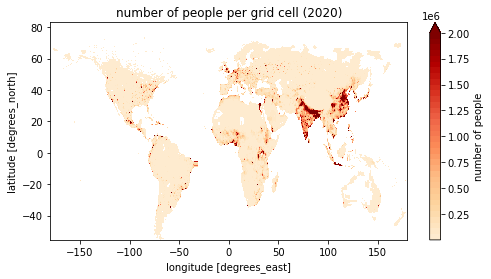

In [261]:
cmap = mpl.cm.OrRd(np.linspace(0,1,40))
cmap = mpl.colors.ListedColormap(cmap[4:,:-1])

gs_population_global.sum(dim='ages').where(gs_population_global.sum(dim='ages')!=0).plot(figsize=(8,4), cmap=cmap, vmax=2e6)
plt.title('number of people per grid cell (2020)')

# check missing data in some places

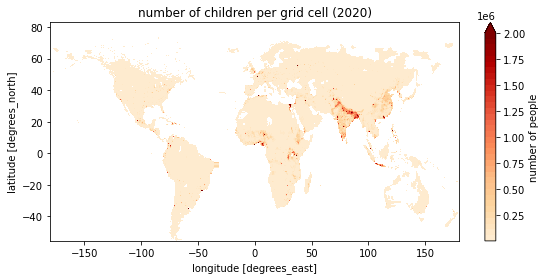

In [264]:
data = gs_population_global.sel(ages=slice(0,18)).sum(dim='ages')

cmap = mpl.cm.OrRd(np.linspace(0,1,40))
cmap = mpl.colors.ListedColormap(cmap[4:,:-1])

data.where(data!=0).plot(cbar_kwargs={'label': 'number of people'}, figsize=(8,4), vmax=2e6, cmap=cmap)
plt.title('number of children per grid cell (2020)')
plt.tight_layout()

figpath='figs/gs_population_children_2020.png'
if not os.path.isfile(figpath):
    plt.savefig(figpath, dpi=300)


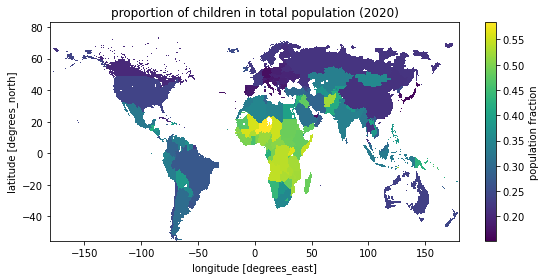

In [227]:
data = gs_population_global.sel(ages=slice(0,18)).sum(dim='ages') / gs_population_global.sum(dim='ages')
data.plot(cbar_kwargs={'label': 'population fraction'}, figsize=(8,4))
plt.title('proportion of children in total population (2020)')
plt.tight_layout()

figpath='figs/gs_population_proportion_children_2020.png'
if not os.path.isfile(figpath):
    plt.savefig(figpath, dpi=300)

Text(0.5, 1.0, 'ratio of children (0-18 yo) to adults (50-68 yo)')

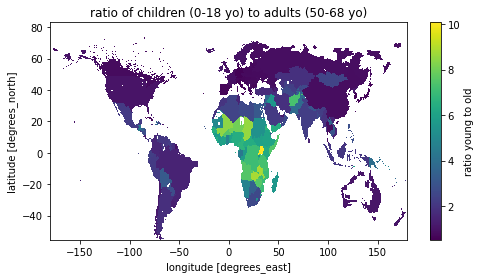

In [235]:
#proportion of  0-18 cfr 50-68

data = gs_population_global.sel(ages=slice(0,18)).sum(dim='ages') / gs_population_global.sel(ages=slice(50,68)).sum(dim='ages') 
data.plot(cbar_kwargs={'label': 'ratio young to old'}, figsize=(8,4))
plt.title('ratio of children (0-18 yo) to adults (50-68 yo)')

Text(0.5, 1.0, 'ratio of children (0-18 yo) to adults (18+ yo)')

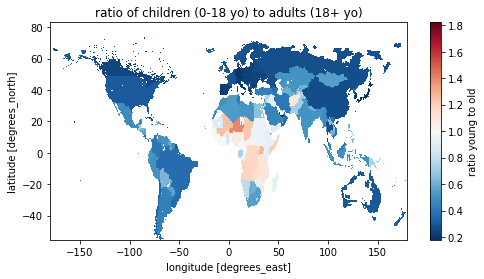

In [259]:
#proportion of  0-18 cfr >18

import matplotlib.colors as colors

data = gs_population_global.sel(ages=slice(0,18)).sum(dim='ages') / gs_population_global.sel(ages=slice(19,110)).sum(dim='ages') 
data.plot(cbar_kwargs={'label': 'ratio young to old'}, figsize=(8,4), cmap='RdBu_r',norm=colors.CenteredNorm(vcenter=1))
plt.title('ratio of children (0-18 yo) to adults (18+ yo)')